# Imports

In [1]:
import warnings
import pandas  as pd

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.datasets import fetch_covtype

from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier

In [2]:
warnings.filterwarnings("ignore")

In [3]:
from dstoolkit.feature_engine import SimpleLagTimeFeatureCreator

In [4]:
from dstoolkit.automl import AutoMLLGBMRegressor, AutoMLLGBMRegressorCV

# Regressor

In [25]:
df = pd.read_csv('../data/global_temperature_time_series.csv', )
df['time'] = pd.to_datetime(df['Year'])
df = df.drop(columns=['Source', 'Year']).rename(columns={'Mean': 'temperature'})

s = SimpleLagTimeFeatureCreator([2, 3, 4, 5, 6], ["mean", "median", "max", "min", "std", "diff", "slope"])
df1 = s.create(df, target='temperature', time='time')
df1 = df1.dropna()

X = df1.drop(columns=['time', 'temperature'])
y = df1[['temperature']]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.55, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.6, random_state=42)

In [27]:
rfe = SequentialFeatureSelector(
    LGBMRegressor(verbose=0), 
    n_features_to_select=20, 
    direction='backward',
    scoring='neg_root_mean_squared_error', 
    cv=3
)
rfe.fit(X_train, y_train['temperature'])

best_features_reg = X_train.loc[:, rfe.get_support()].columns.tolist()

In [37]:
a = AutoMLLGBMRegressor(
    X_train, y_train, 
    X_valid, y_valid,
    X_test, y_test,
    target='temperature',
    best_features=best_features_reg,
    n_trials=50,
    scoring='root_mean_squared_error'
)

In [38]:
a.train()

In [39]:
a.get_metrics()

Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0   Train  0.987406  0.034668  0.027240  5.643267e+11  0.045194   
1   Valid  0.911242  0.090557  0.071248  3.525480e+12  0.119737   
2    Test  0.911454  0.094987  0.073746  1.299955e+00  0.124965   
3   Train  0.982190  0.041209  0.033249  4.788525e+11  0.053744   
4   Valid  0.909586  0.092335  0.073149  3.618800e+12  0.120849   
5    Test  0.916321  0.093702  0.071355  1.298190e+00  0.121482   
6   Train  0.940192  0.075559  0.059814  8.566546e+11  0.098488   
7   Valid  0.918396  0.088014  0.069708  3.225899e+12  0.114810   
8    Test  0.921753  0.090958  0.072746  1.269381e+00  0.117472   

   Explained Variance               Model  
0            0.987406          Base Model  
1            0.911242          Base Model  
2            0.911752          Base Model  
3            0.982190  Best Feature Model  
4            0.909586  Best Feature Model  
5            0.916690  Best Feature Model  
6            0.940192   Best Params Model  
7            0.918400   Best Params Model  
8            0.921988   Best Params Model

base_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0   Train  0.987406  0.034668  0.027240  5.643267e+11  0.045194   
1   Valid  0.911242  0.090557  0.071248  3.525480e+12  0.119737   
2    Test  0.911454  0.094987  0.073746  1.299955e+00  0.124965   

   Explained Variance  
0            0.987406  
1            0.911242  
2            0.911752

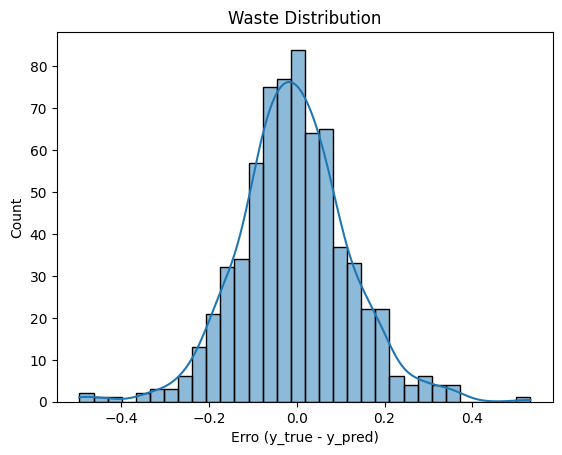

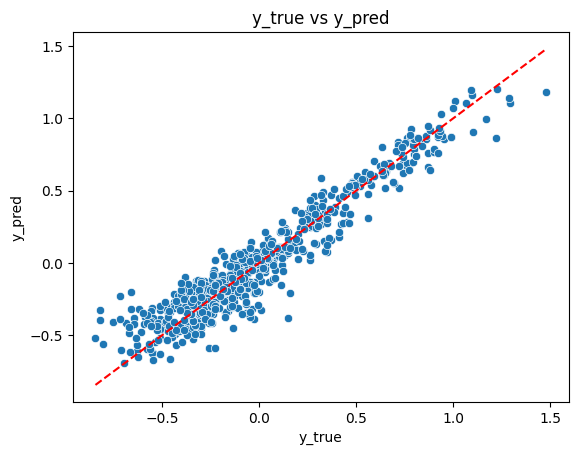

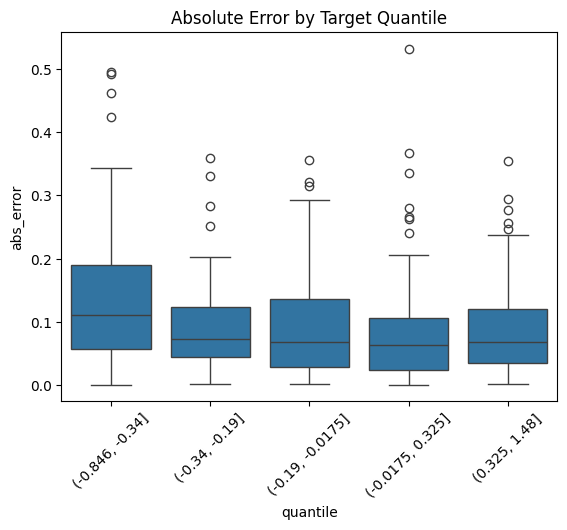

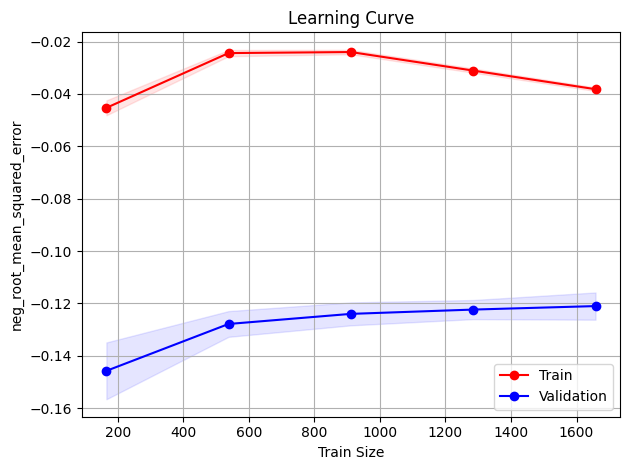

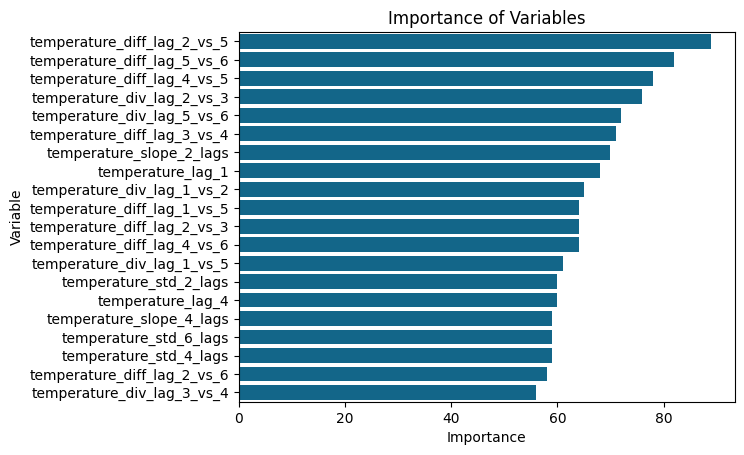

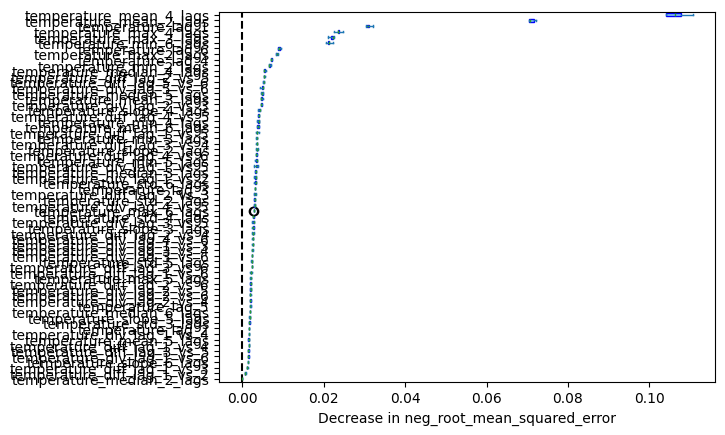

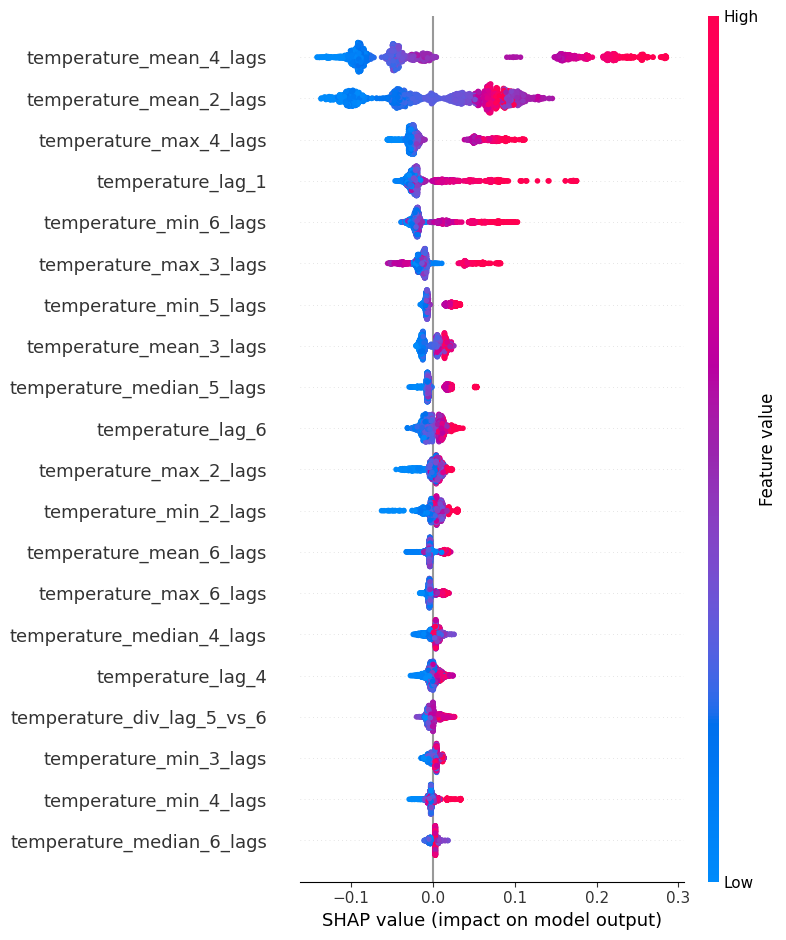

best_feature_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0   Train  0.982190  0.041209  0.033249  4.788525e+11  0.053744   
1   Valid  0.909586  0.092335  0.073149  3.618800e+12  0.120849   
2    Test  0.916321  0.093702  0.071355  1.298190e+00  0.121482   

   Explained Variance  
0            0.982190  
1            0.909586  
2            0.916690

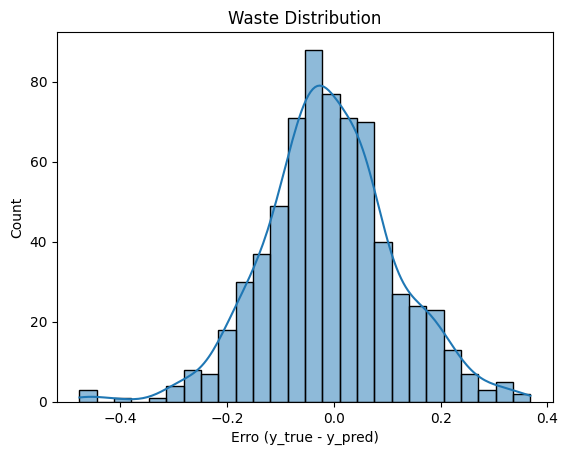

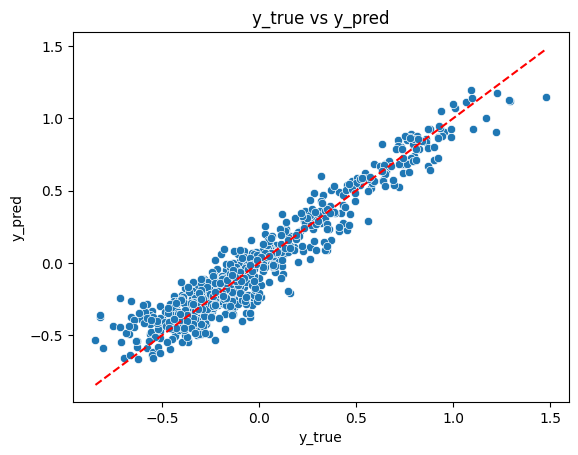

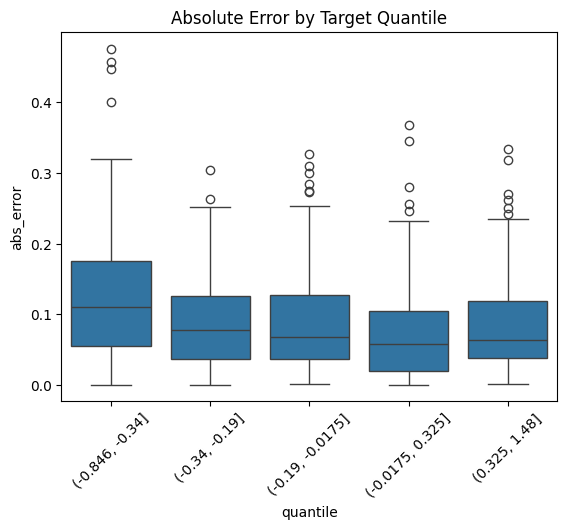

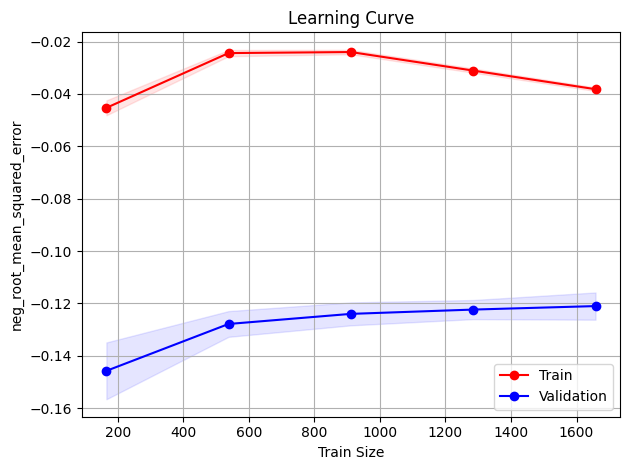

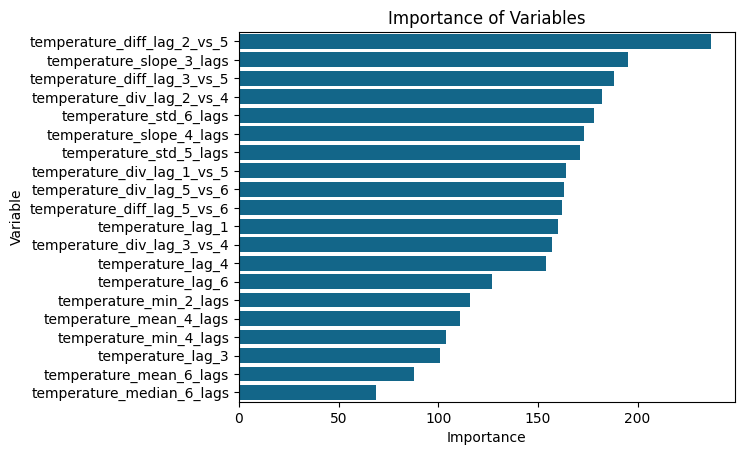

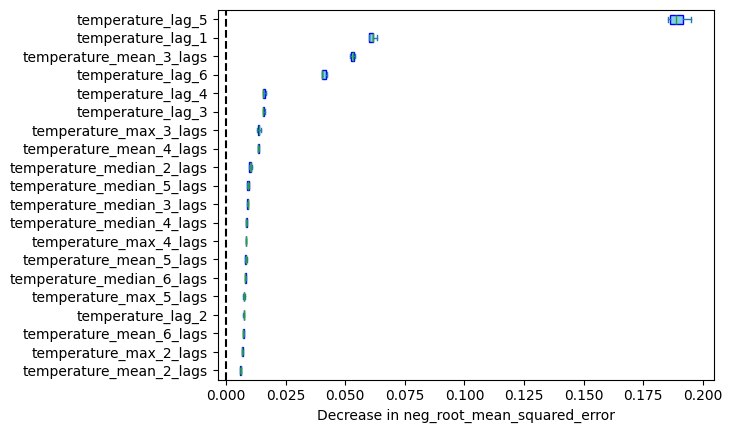

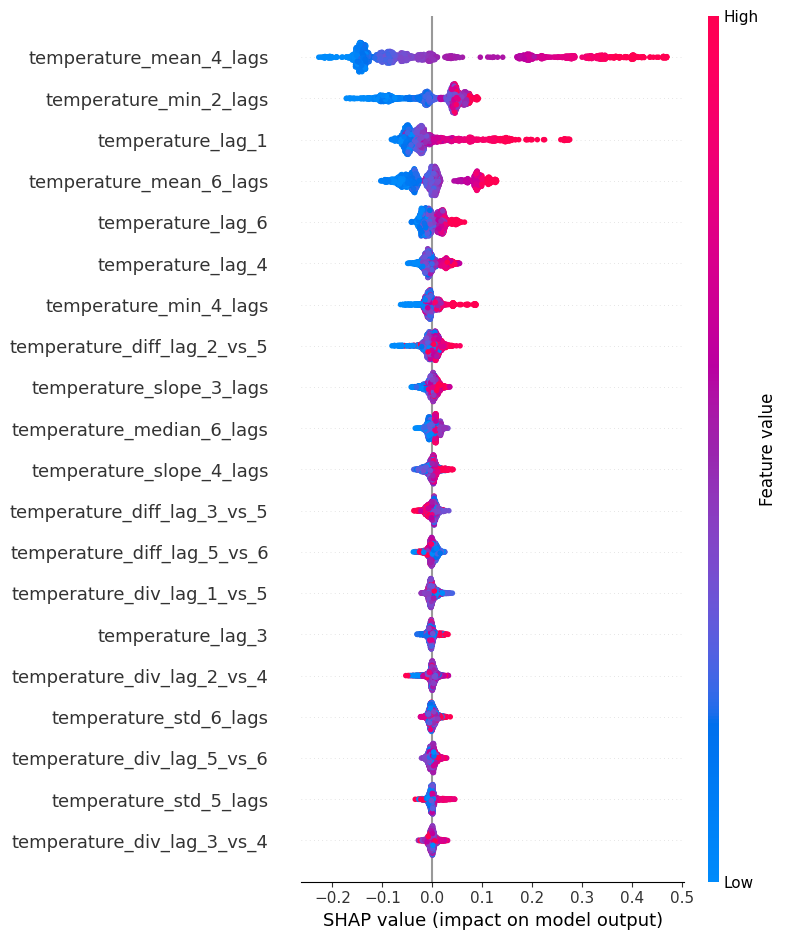

best_params_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0   Train  0.940192  0.075559  0.059814  8.566546e+11  0.098488   
1   Valid  0.918396  0.088014  0.069708  3.225899e+12  0.114810   
2    Test  0.921753  0.090958  0.072746  1.269381e+00  0.117472   

   Explained Variance  
0            0.940192  
1            0.918400  
2            0.921988

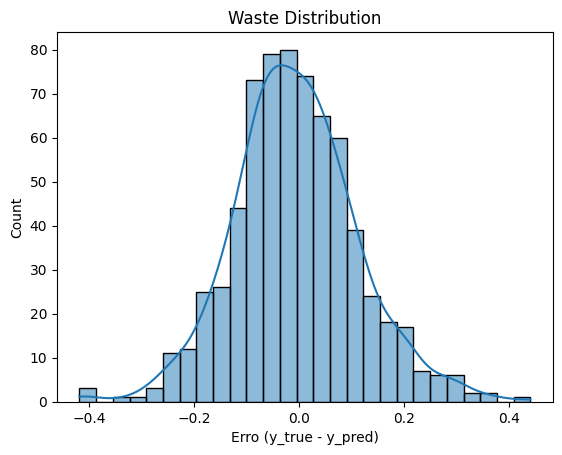

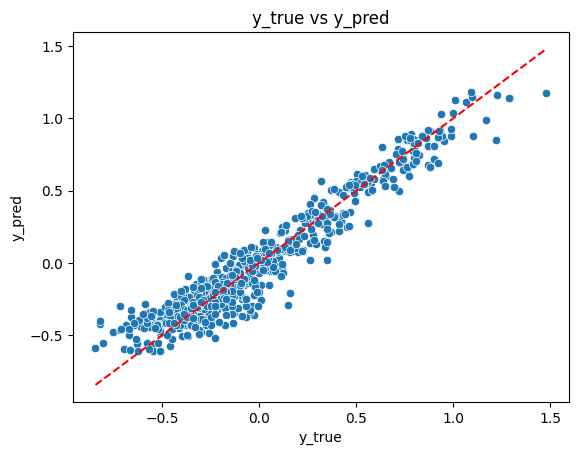

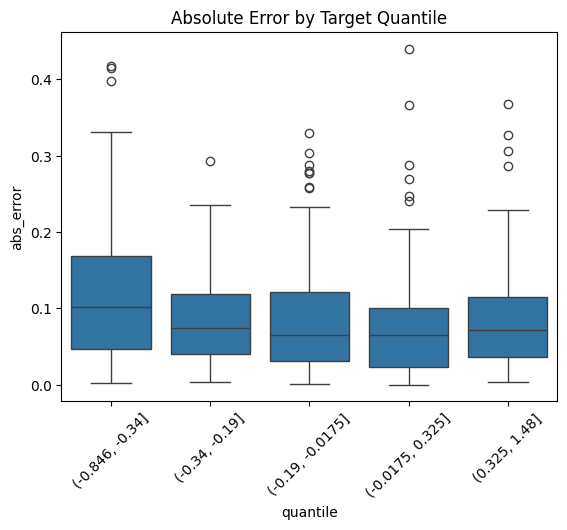

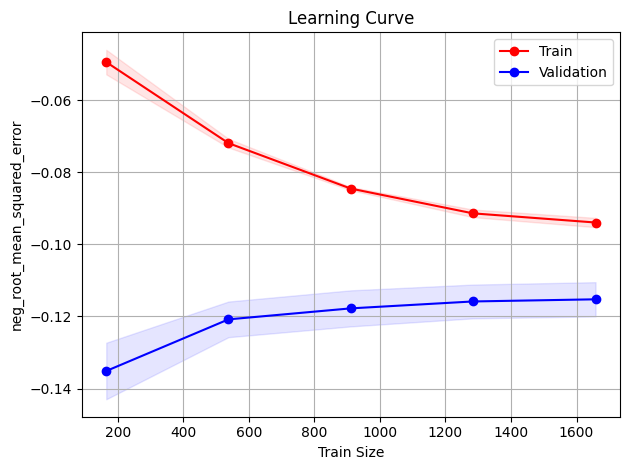

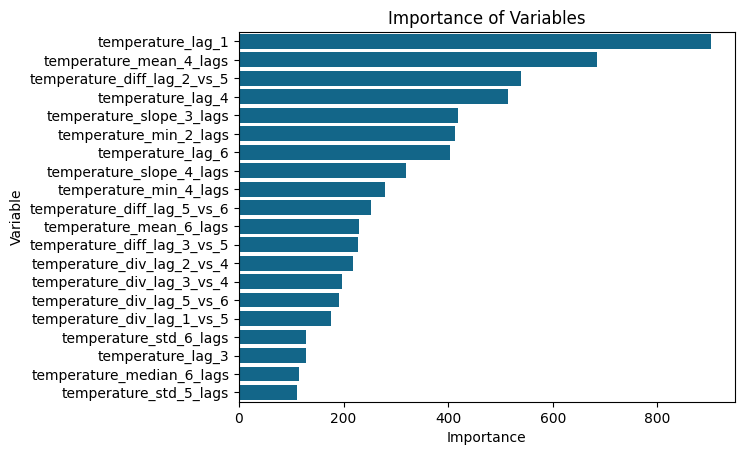

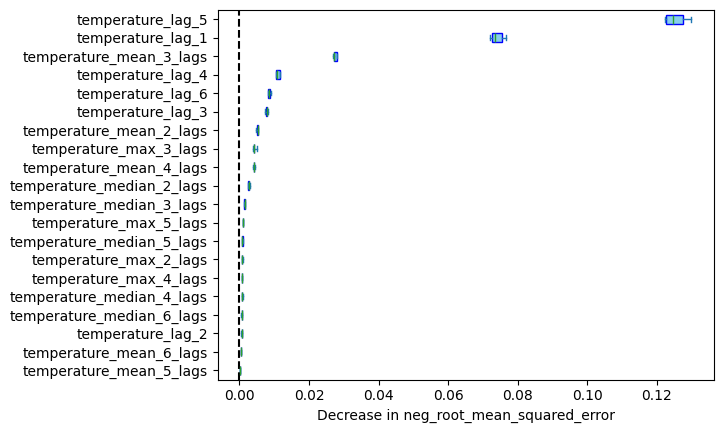

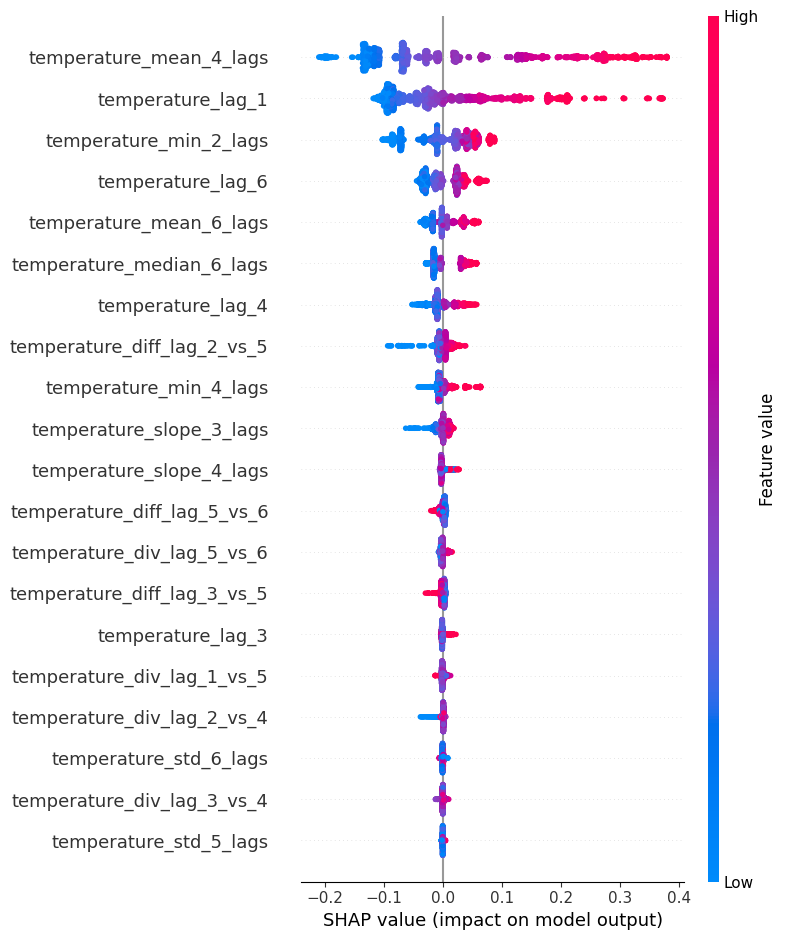

In [40]:
a.get_result_analysis()

In [32]:
acv = AutoMLLGBMRegressorCV(
    X_train, y_train, 
    X_test, y_test,
    target='temperature',
    cv=KFold(shuffle=True, random_state=42),
    best_features=best_features_reg,
    n_trials=50,
    scoring='mean_absolute_error',
    random_state=42
)

In [33]:
acv.train()

In [34]:
acv.get_metrics()

Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0  Train CV  0.908385  0.091670  0.072982  1.234447e+12  0.121017   
1      Test  0.911454  0.094987  0.073746  1.299955e+00  0.124965   
2  Train CV  0.912559  0.090638  0.071713  9.396324e+11  0.118250   
3      Test  0.916321  0.093702  0.071355  1.298190e+00  0.121482   
4  Train CV  0.915560  0.089005  0.071618  1.163013e+12  0.116308   
5      Test  0.918544  0.091964  0.071160  1.276041e+00  0.119857   

   Explained Variance               Model  
0            0.909765          Base Model  
1            0.911752          Base Model  
2            0.913835  Best Feature Model  
3            0.916690  Best Feature Model  
4            0.916761   Best Params Model  
5            0.918777   Best Params Model

base_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0  Train CV  0.908385  0.091670  0.072982  1.234447e+12  0.121017   
1      Test  0.911454  0.094987  0.073746  1.299955e+00  0.124965   

   Explained Variance  
0            0.909765  
1            0.911752

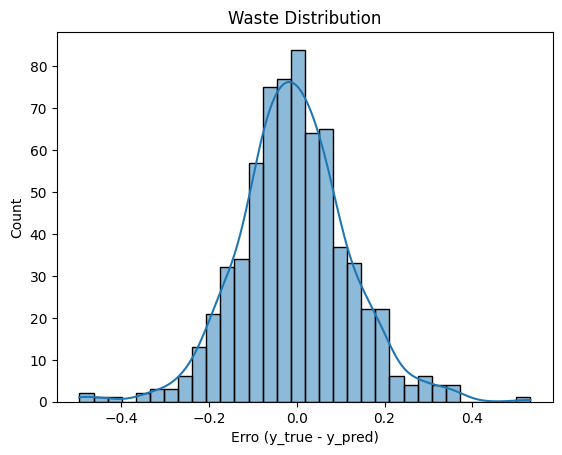

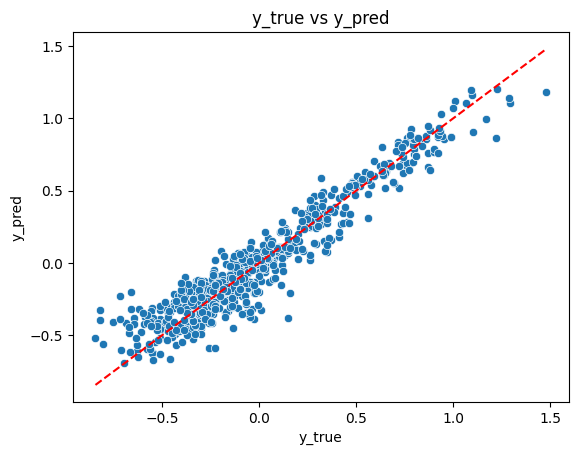

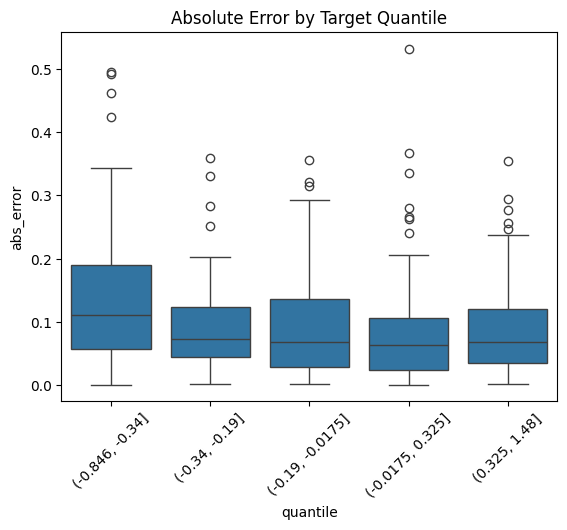

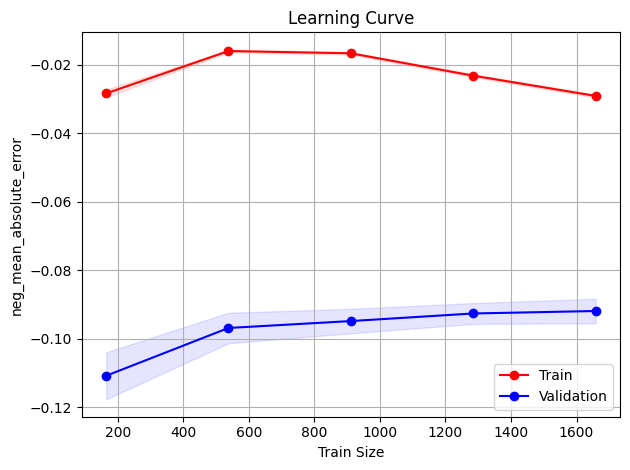

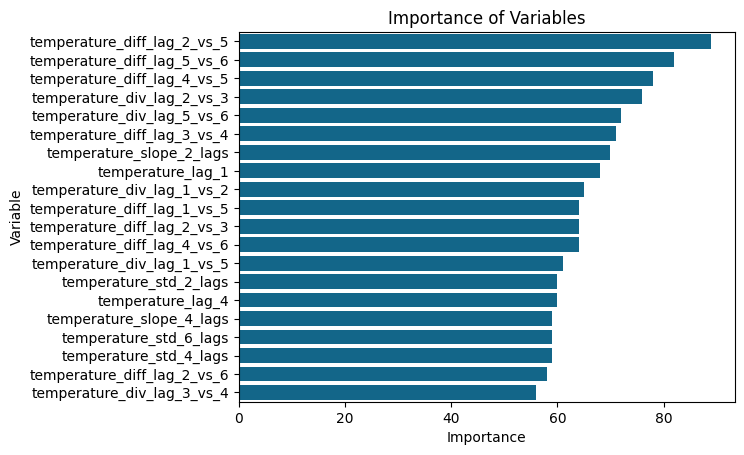

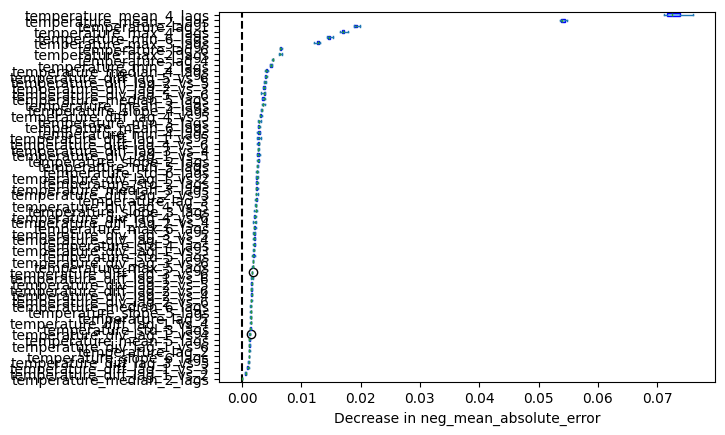

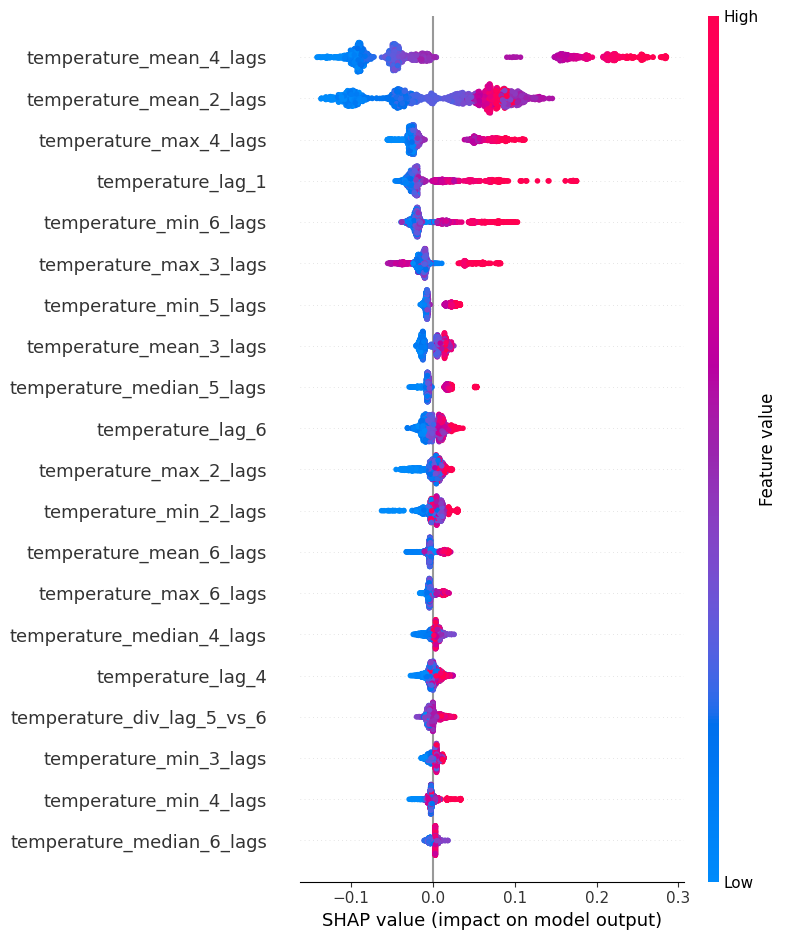

best_feature_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0  Train CV  0.912559  0.090638  0.071713  9.396324e+11  0.118250   
1      Test  0.916321  0.093702  0.071355  1.298190e+00  0.121482   

   Explained Variance  
0            0.913835  
1            0.916690

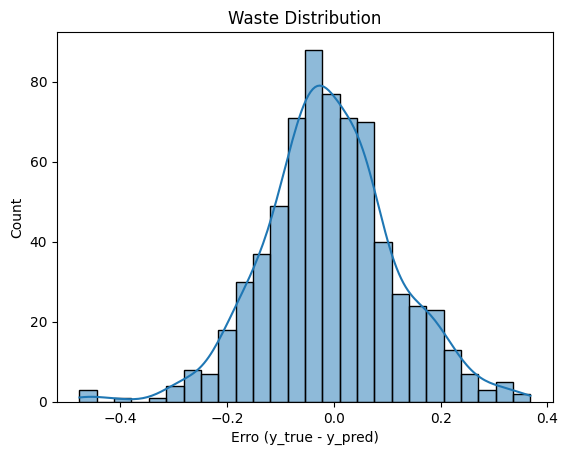

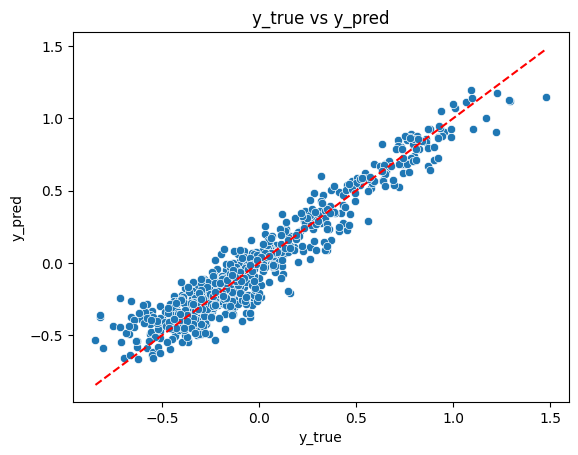

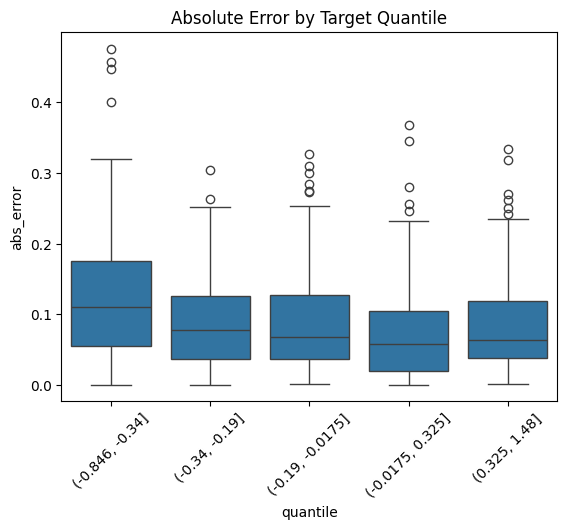

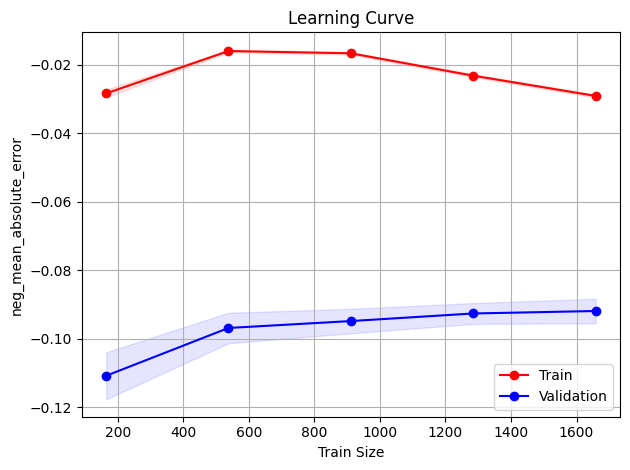

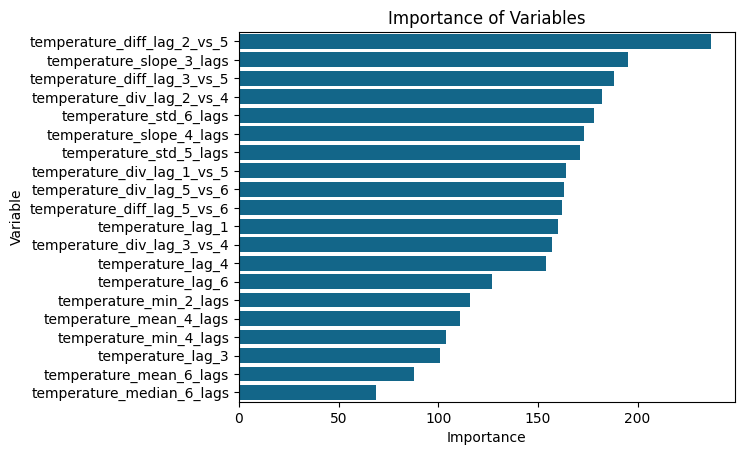

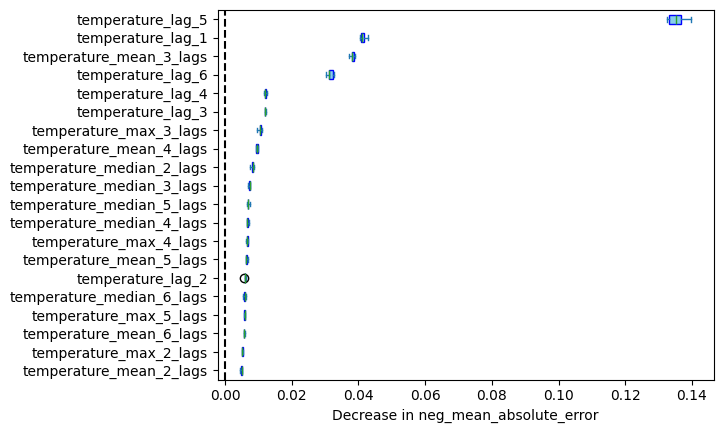

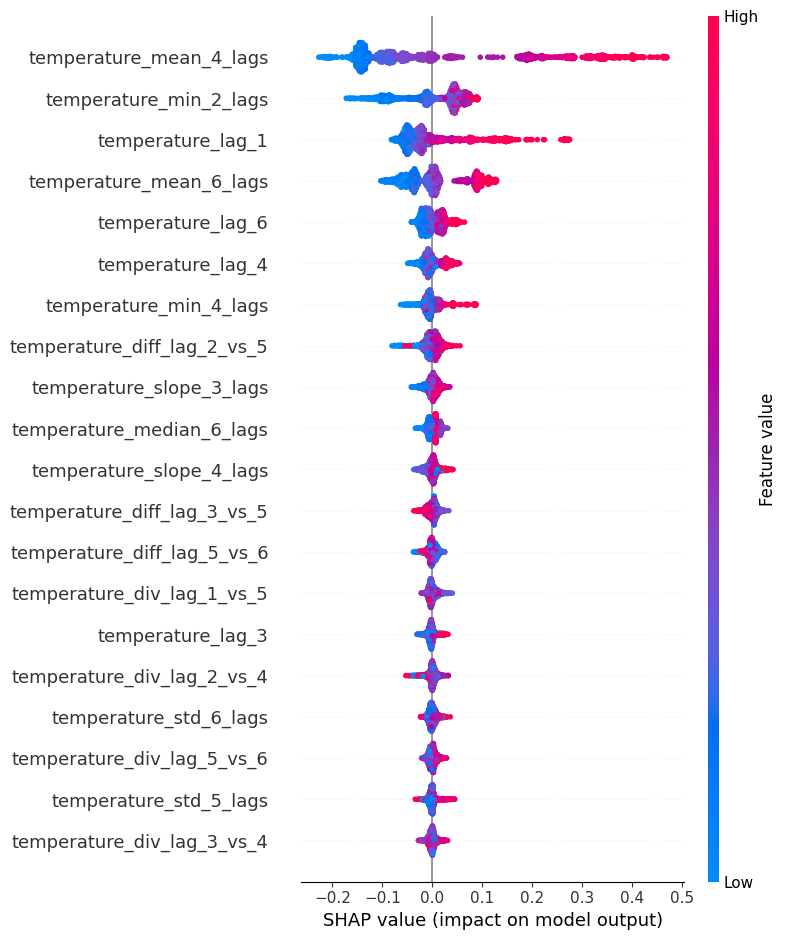

best_params_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0  Train CV  0.915560  0.089005  0.071618  1.163013e+12  0.116308   
1      Test  0.918544  0.091964  0.071160  1.276041e+00  0.119857   

   Explained Variance  
0            0.916761  
1            0.918777

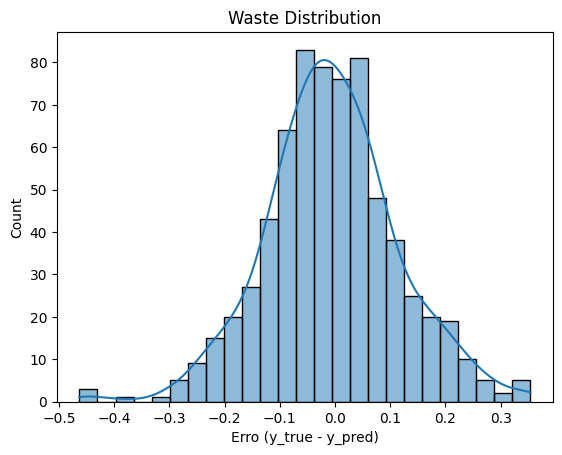

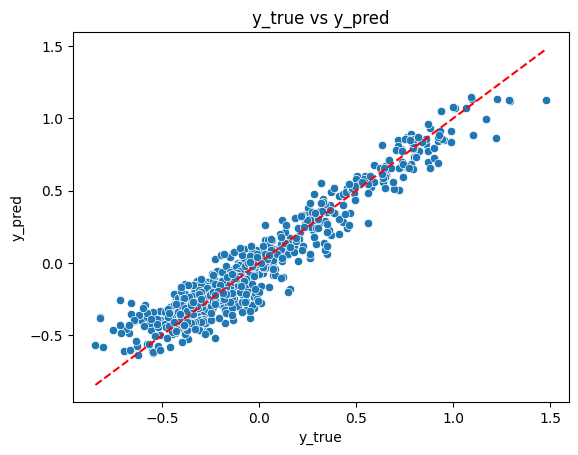

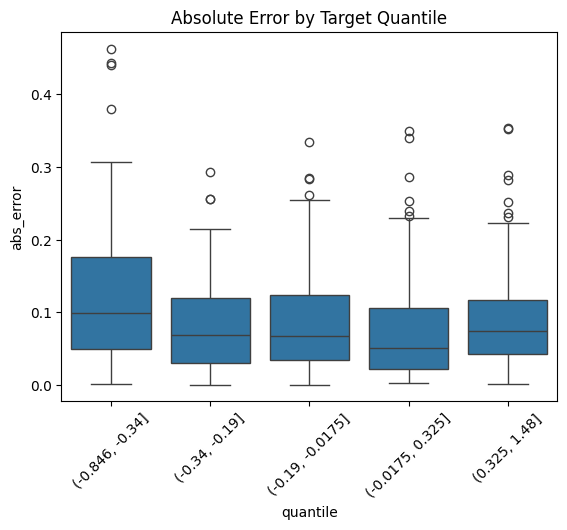

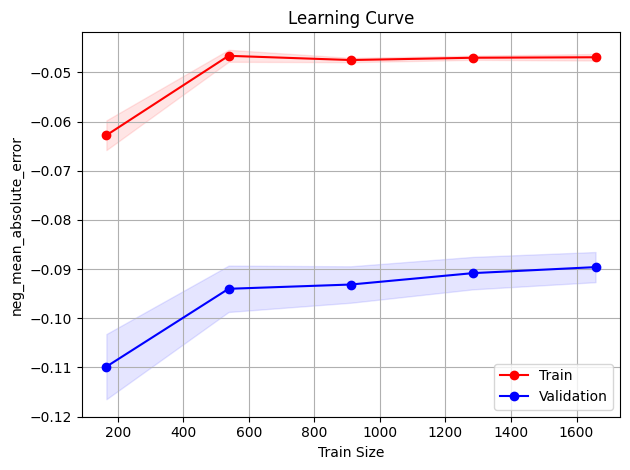

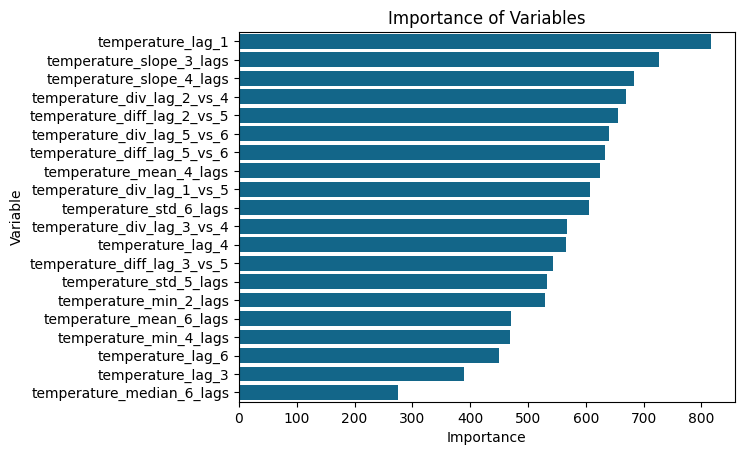

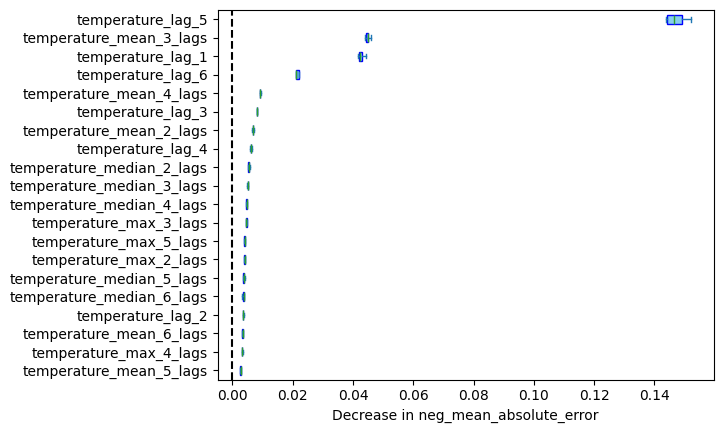

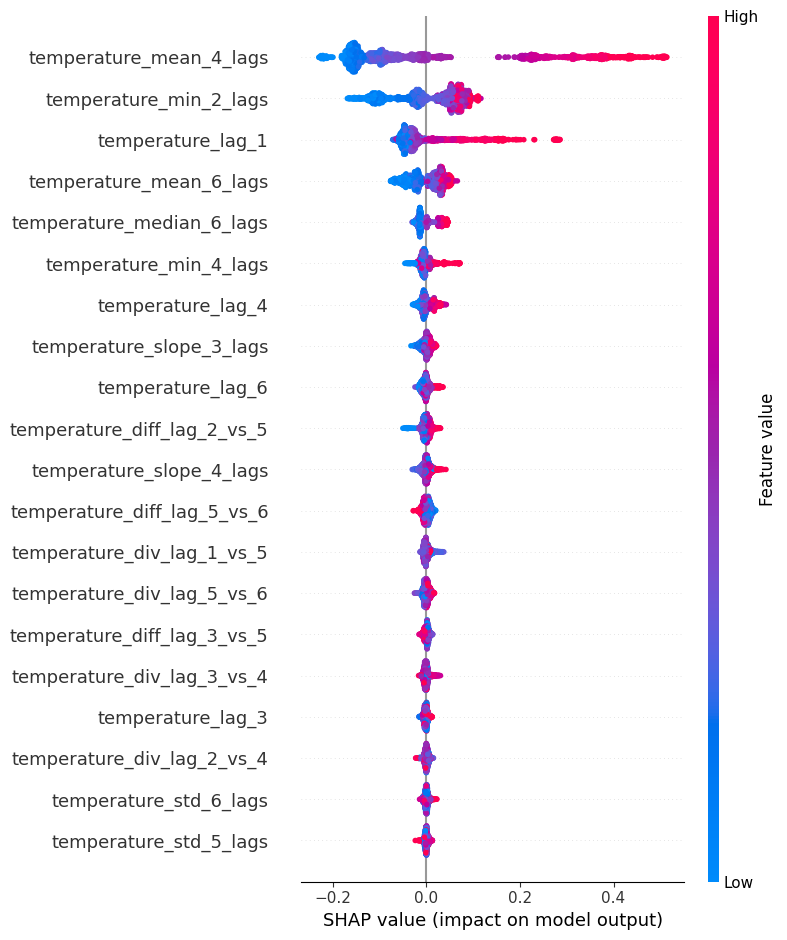

In [35]:
acv.get_result_analysis()

# Classifier

In [7]:
from dstoolkit.automl import AutoMLLGBMClassifier, AutoMLLGBMClassifierCV

In [8]:
df = pd.read_csv('../data/cs-training.csv')

X = df.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1)
y = df[['SeriousDlqin2yrs']].rename({'SeriousDlqin2yrs': 'target'}, axis=1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, random_state=42, stratify=y['target'])
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.6, random_state=42, stratify=y_temp['target'])

rfe = SequentialFeatureSelector(
    LGBMClassifier(verbose=0), 
    n_features_to_select=6, 
    direction='backward', 
    scoring='neg_brier_score', 
    cv=3
)
rfe.fit(X_train, y_train['target'])

best_features_class = X_train.loc[:, rfe.get_support()].columns.tolist()

In [9]:
a = AutoMLLGBMClassifier(
    X_train, y_train, 
    X_valid, y_valid, 
    X_test, y_test, 
    target='target', 
    best_features=best_features_class,
    n_trials=50,
    scoring='brier'
)

In [10]:
a.train()

In [11]:
a.get_metrics()

Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0   Train  0.246231           0.740497   0.477276  0.521941  0.498611   
1   Valid  0.195980           0.732529   0.400960  0.520781  0.453083   
2    Test  0.175879           0.736884   0.363294  0.541771  0.434935   
3   Train  0.216080           0.736545   0.437360  0.521110  0.475576   
4   Valid  0.201005           0.727605   0.410144  0.507481  0.453650   
5    Test  0.201005           0.720826   0.394255  0.496259  0.439415   
6   Train  0.201005           0.723496   0.407327  0.499003  0.448528   
7   Valid  0.206030           0.722697   0.422325  0.493766  0.455260   
8    Test  0.226131           0.712086   0.420145  0.470698  0.443987   

        AUC        KS     Brier               Model  
0  0.902256  0.644746  0.044558          Base Model  
1  0.867222  0.579020  0.048628          Base Model  
2  0.859473  0.557068  0.049605          Base Model  
3  0.890542  0.614949  0.046003  Best Feature Model  
4  0.862060  0.572807  0.048932  Best Feature Model  
5  0.856866  0.551384  0.049731  Best Feature Model  
6  0.865397  0.572885  0.048613   Best Params Model  
7  0.864833  0.576556  0.048640   Best Params Model  
8  0.857473  0.553055  0.049286   Best Params Model

base_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0   Train  0.246231           0.740497   0.477276  0.521941  0.498611   
1   Valid  0.195980           0.732529   0.400960  0.520781  0.453083   
2    Test  0.175879           0.736884   0.363294  0.541771  0.434935   

        AUC        KS     Brier  
0  0.902256  0.644746  0.044558  
1  0.867222  0.579020  0.048628  
2  0.859473  0.557068  0.049605

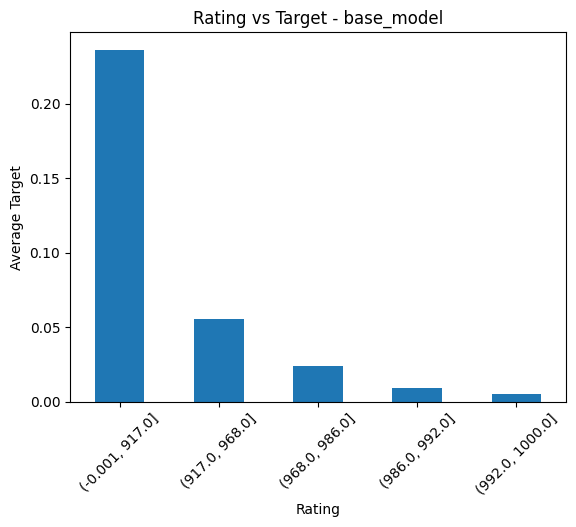

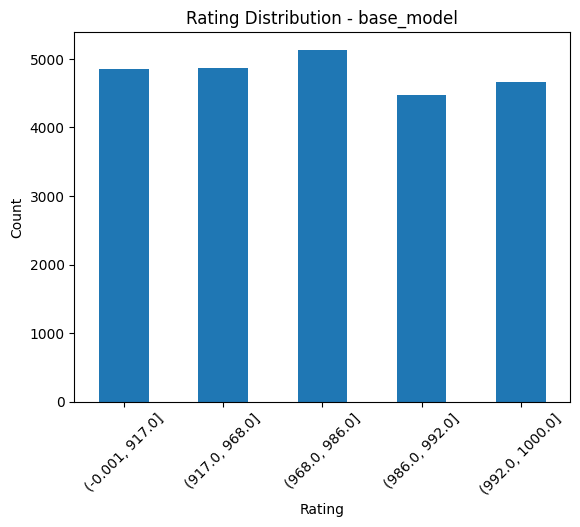

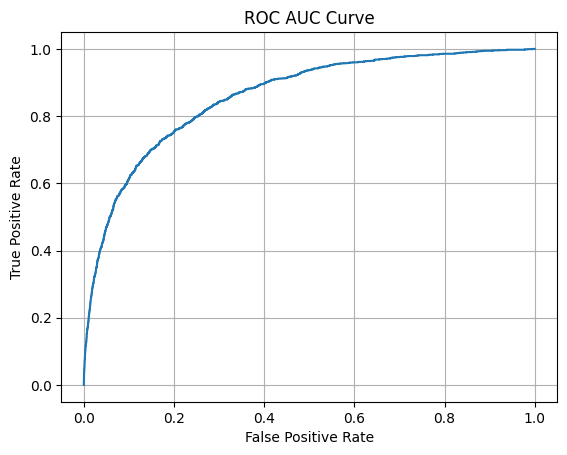

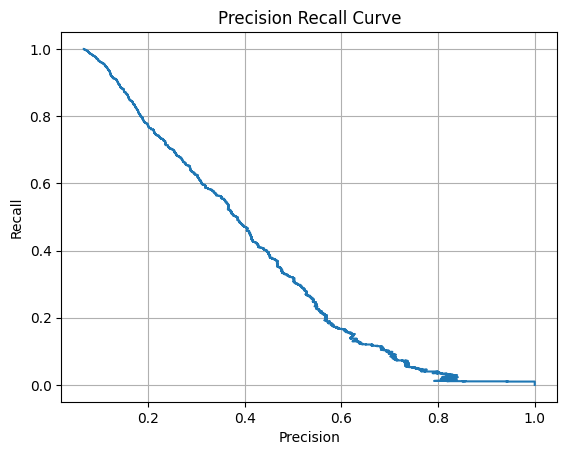

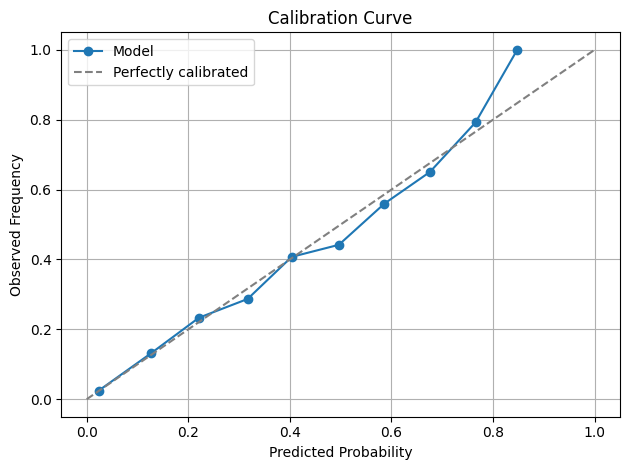

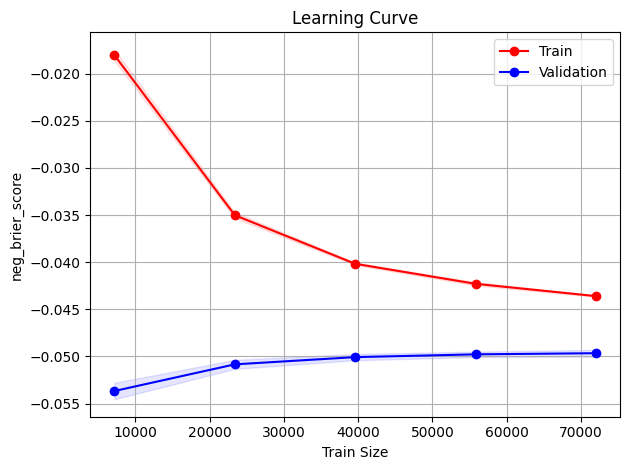

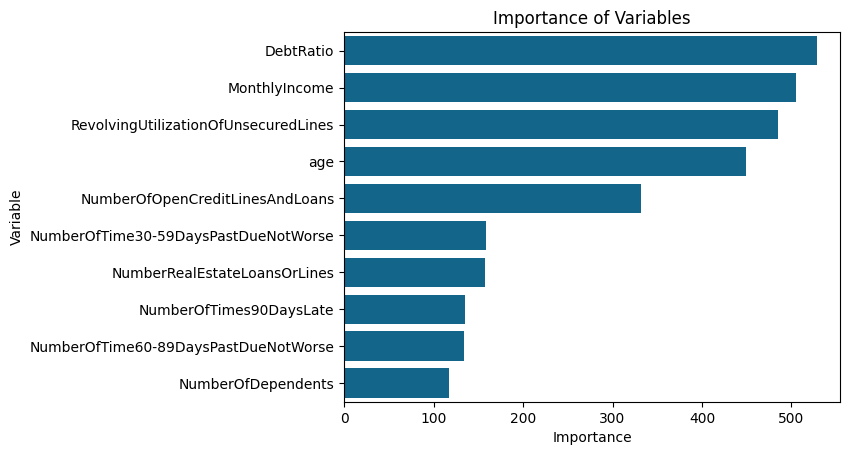

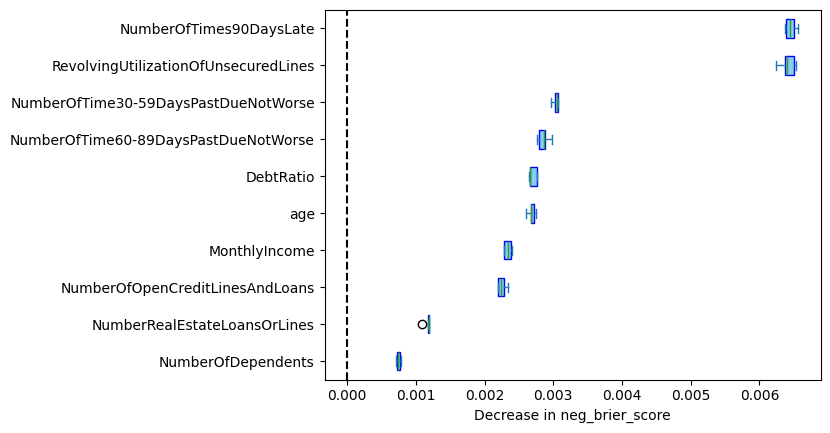

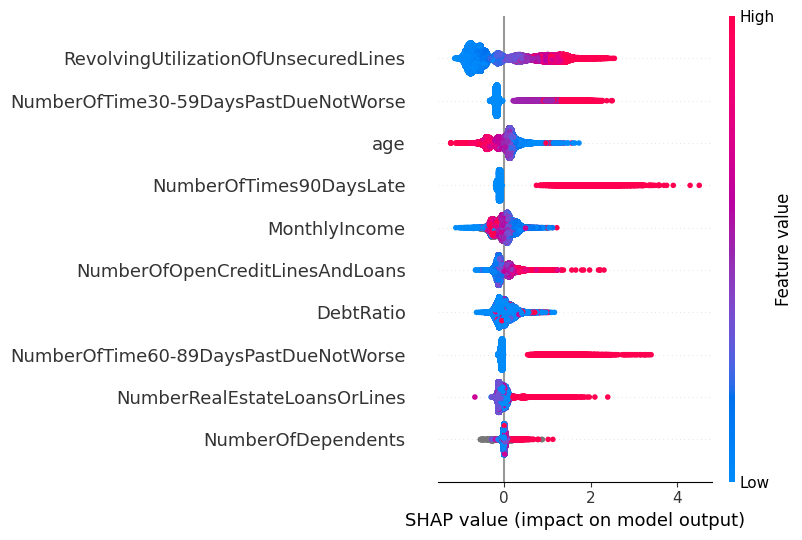

best_feature_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0   Train  0.216080           0.736545   0.437360  0.521110  0.475576   
1   Valid  0.201005           0.727605   0.410144  0.507481  0.453650   
2    Test  0.201005           0.720826   0.394255  0.496259  0.439415   

        AUC        KS     Brier  
0  0.890542  0.614949  0.046003  
1  0.862060  0.572807  0.048932  
2  0.856866  0.551384  0.049731

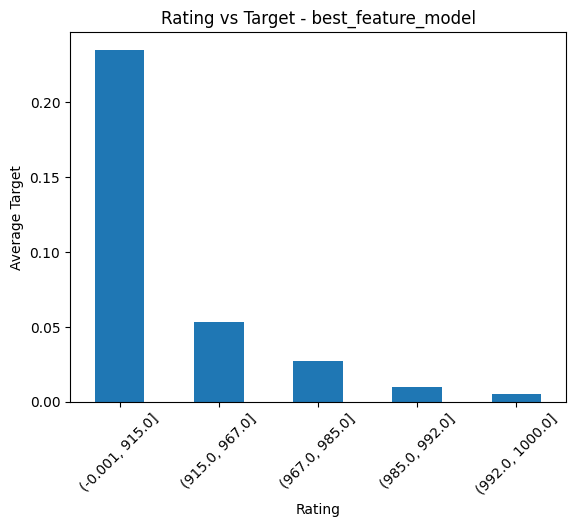

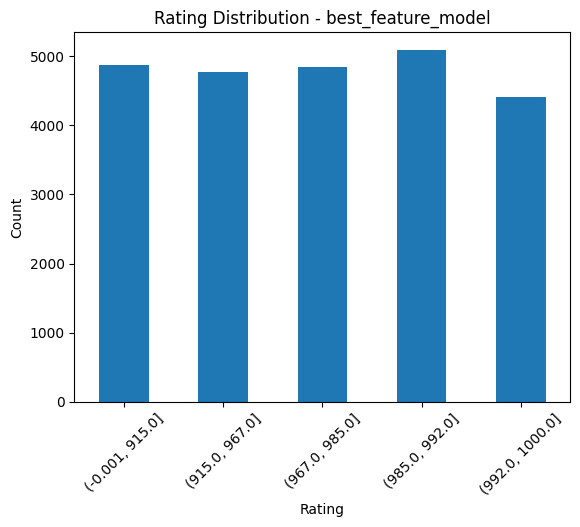

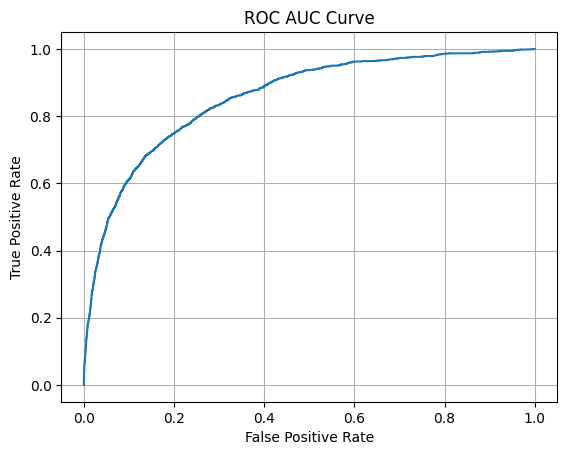

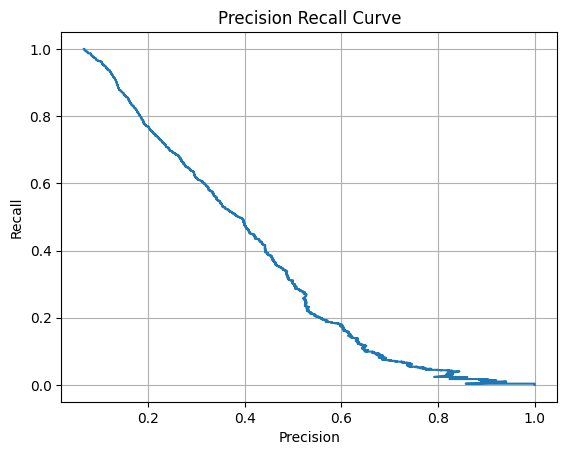

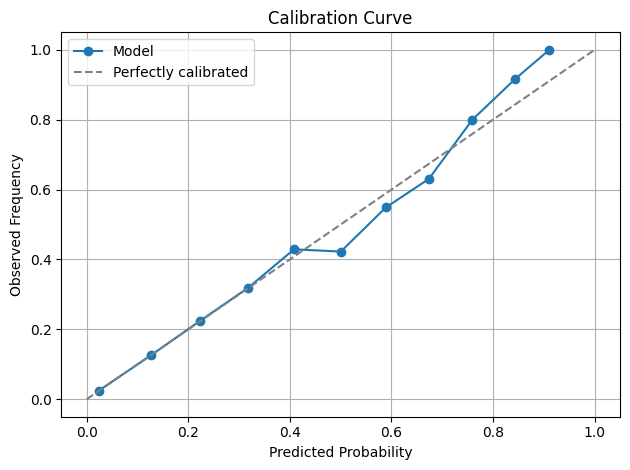

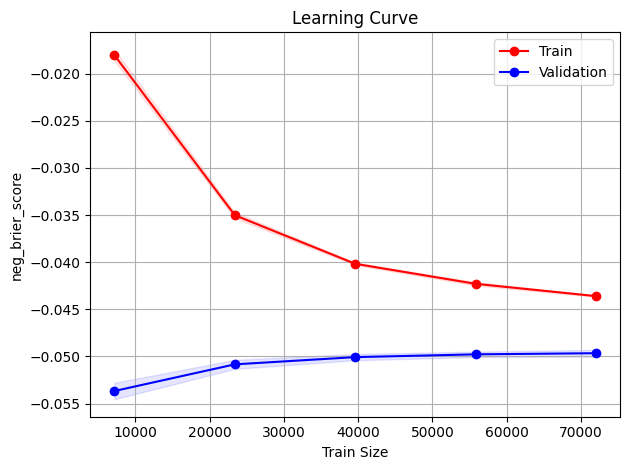

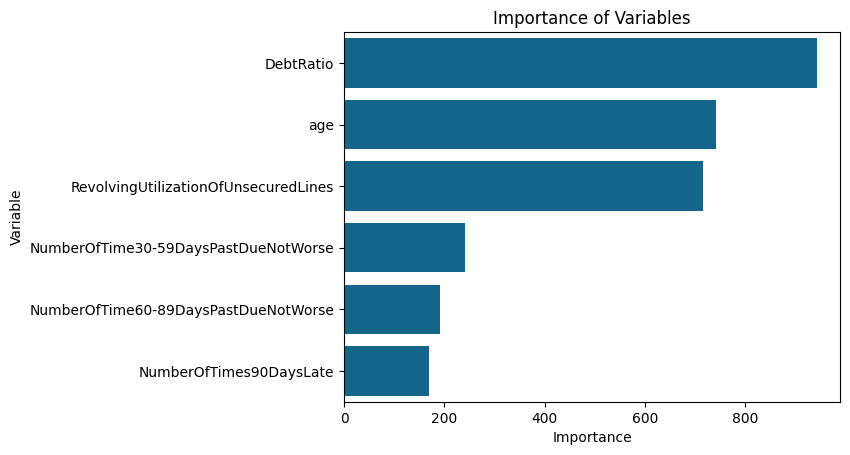

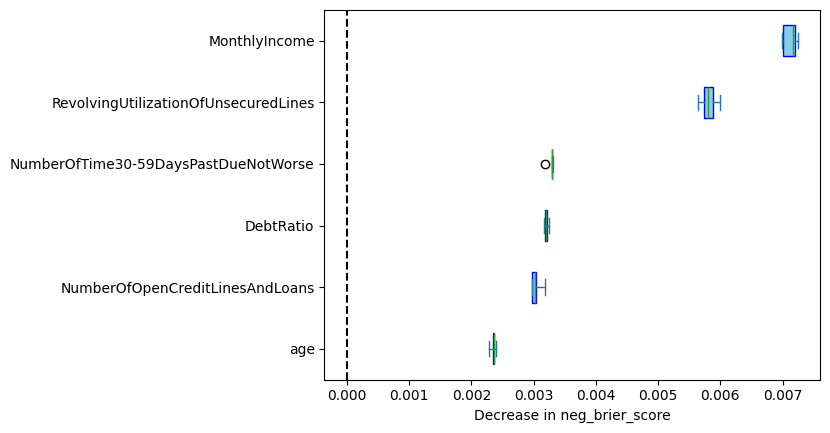

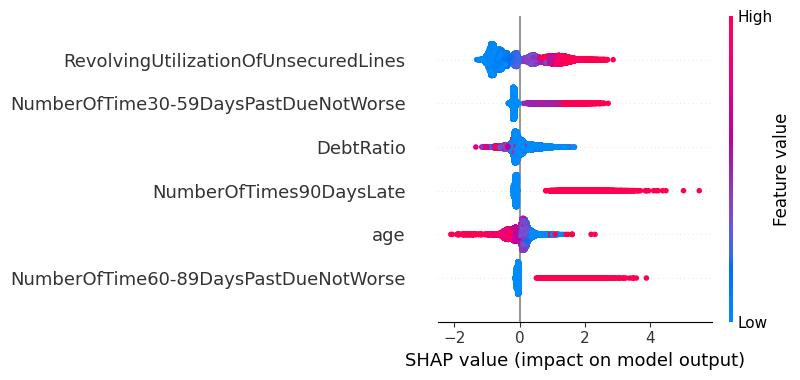

best_params_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0   Train  0.201005           0.723496   0.407327  0.499003  0.448528   
1   Valid  0.206030           0.722697   0.422325  0.493766  0.455260   
2    Test  0.226131           0.712086   0.420145  0.470698  0.443987   

        AUC        KS     Brier  
0  0.865397  0.572885  0.048613  
1  0.864833  0.576556  0.048640  
2  0.857473  0.553055  0.049286

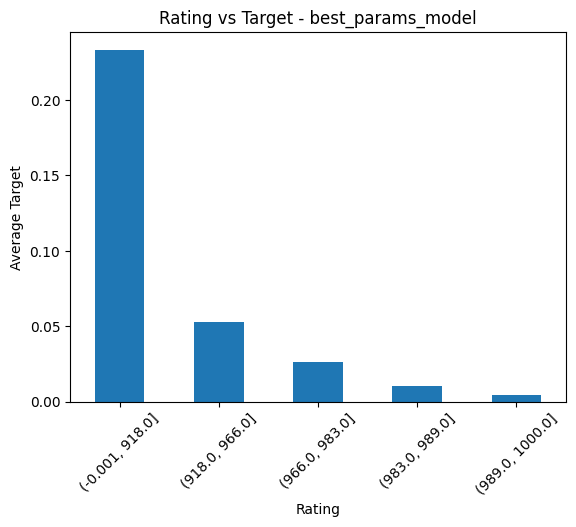

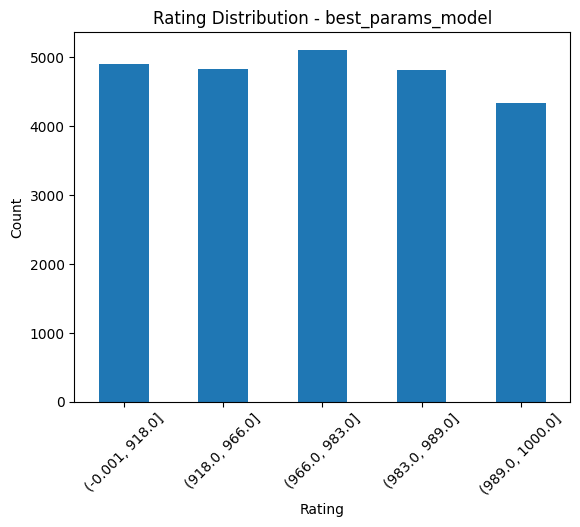

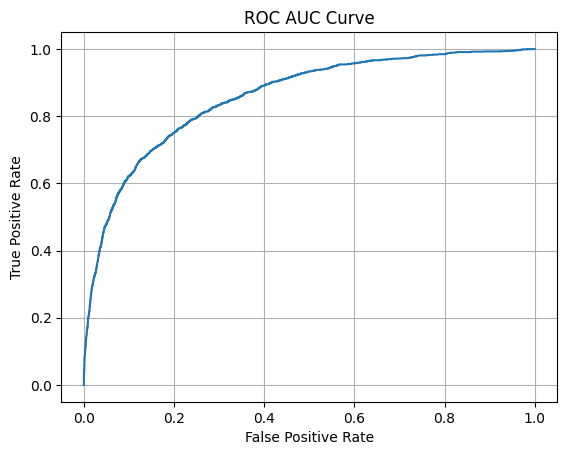

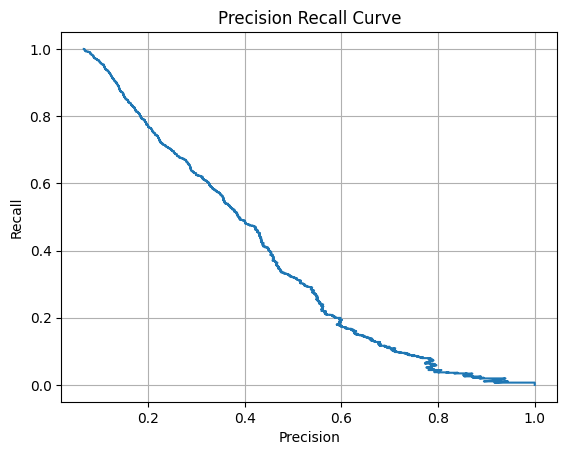

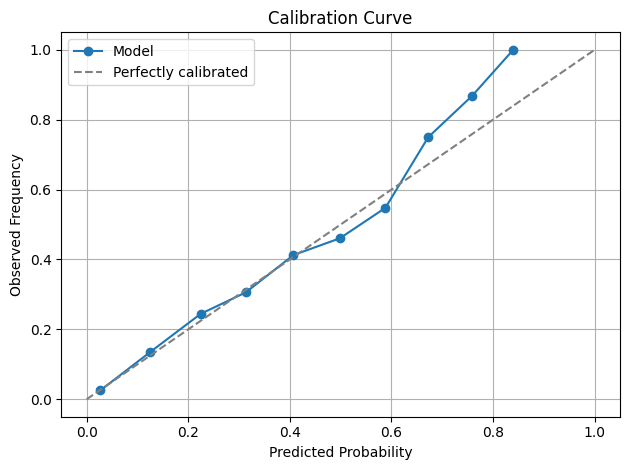

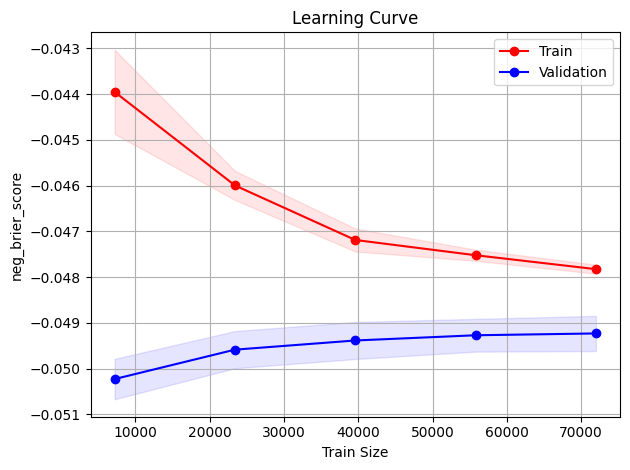

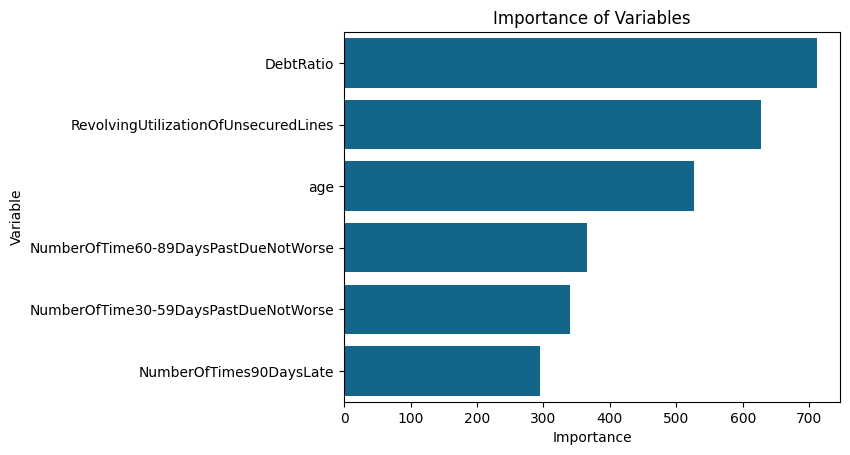

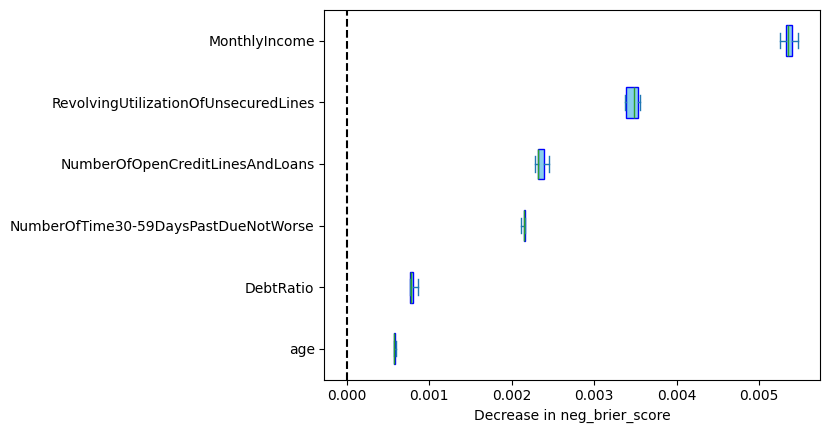

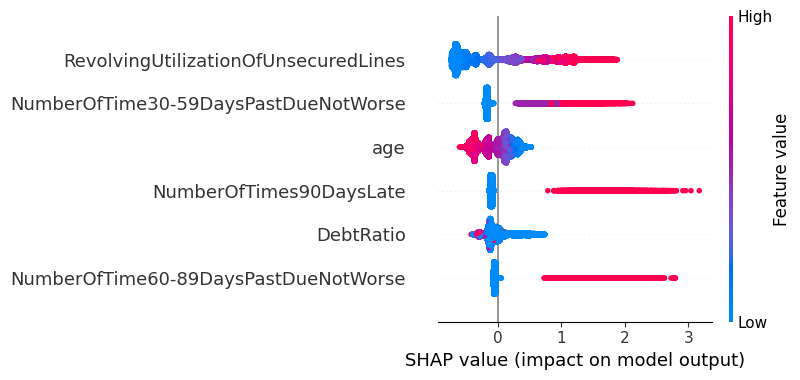

In [12]:
a.get_result_analysis()

In [13]:
acv = AutoMLLGBMClassifierCV(
    X_train, y_train, 
    X_test, y_test, 
    target='target', 
    best_features=best_features_class,
    n_trials=50,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='brier'
)

In [14]:
acv.train()

In [15]:
acv.get_metrics()

Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0  Train CV  0.500000           0.586257   0.580235  0.182017  0.276759   
1      Test  0.175879           0.736884   0.363294  0.541771  0.434935   
2  Train CV  0.500000           0.584893   0.586042  0.178859  0.273675   
3      Test  0.201005           0.720826   0.394255  0.496259  0.439415   
4  Train CV  0.500000           0.580335   0.610947  0.168386  0.263759   
5      Test  0.221106           0.714600   0.414278  0.477556  0.443672   

        AUC        KS     Brier               Model  
0  0.861749  0.571792  0.049660          Base Model  
1  0.859473  0.557068  0.049605          Base Model  
2  0.857731  0.565200  0.049887  Best Feature Model  
3  0.856866  0.551384  0.049731  Best Feature Model  
4  0.859811  0.568751  0.049414   Best Params Model  
5  0.857228  0.552451  0.049327   Best Params Model

base_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0  Train CV  0.500000           0.586257   0.580235  0.182017  0.276759   
1      Test  0.175879           0.736884   0.363294  0.541771  0.434935   

        AUC        KS     Brier  
0  0.861749  0.571792  0.049660  
1  0.859473  0.557068  0.049605

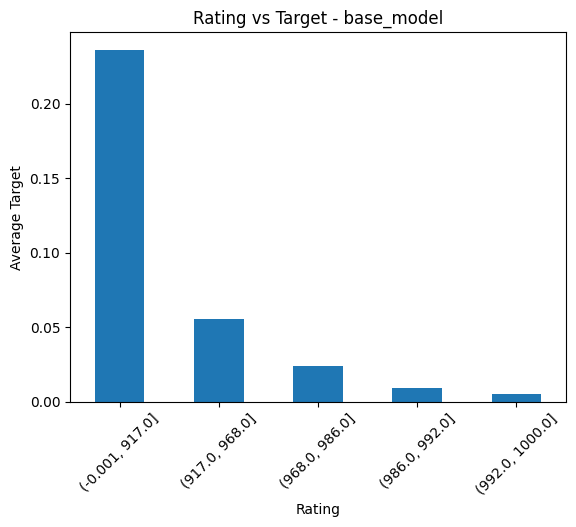

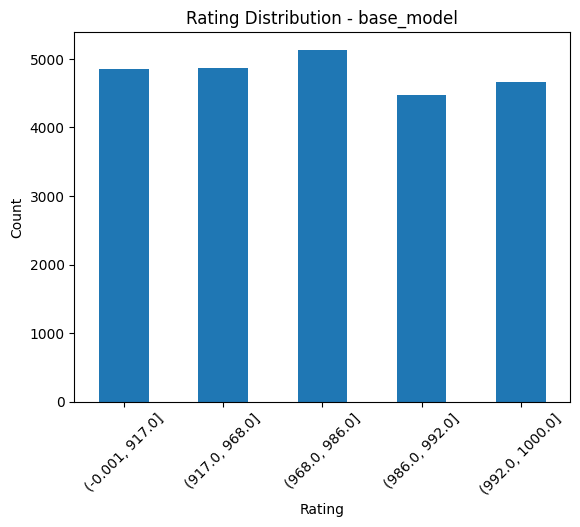

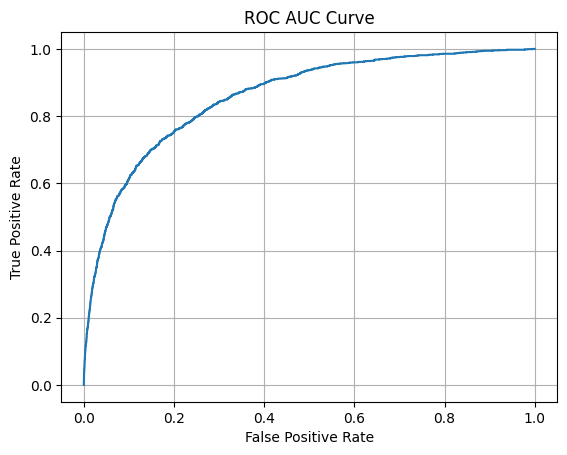

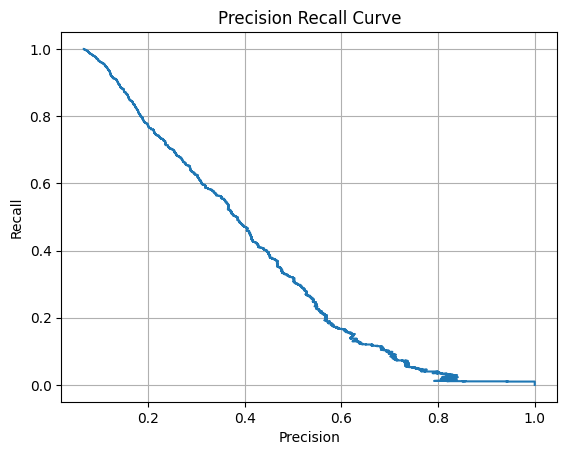

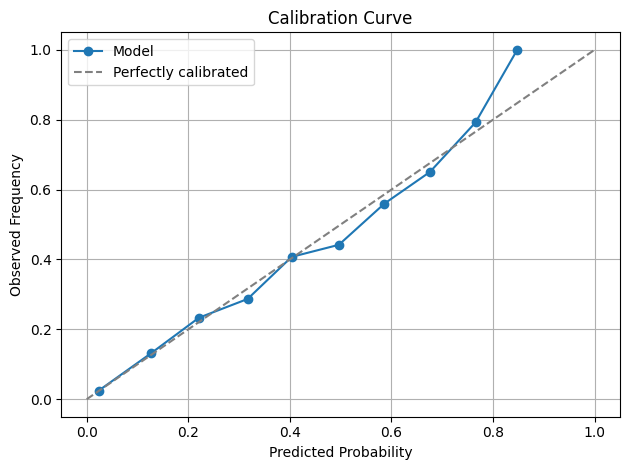

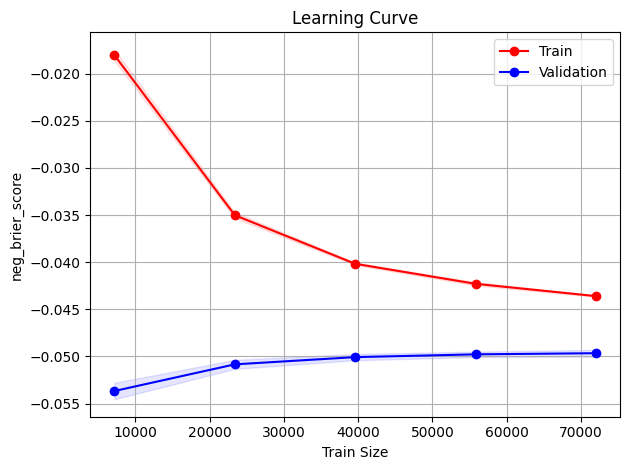

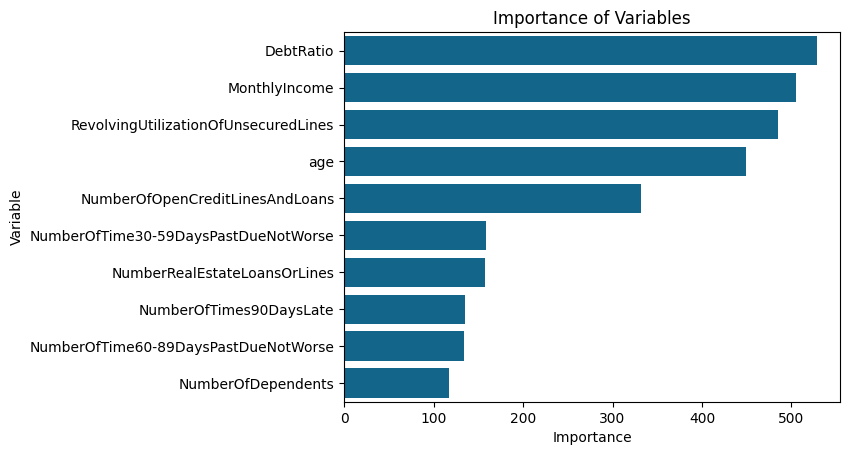

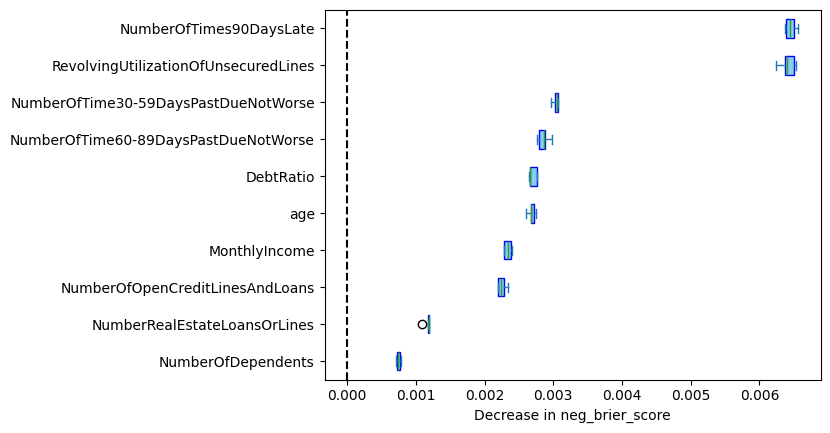

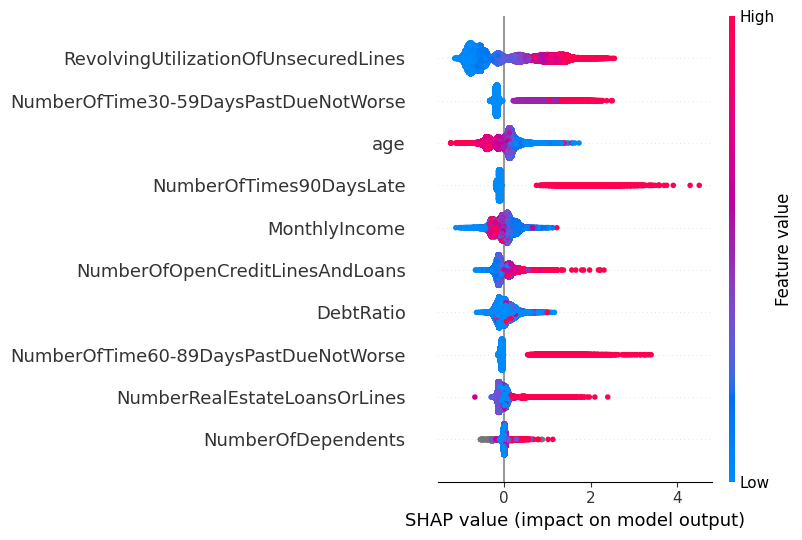

best_feature_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0  Train CV  0.500000           0.584893   0.586042  0.178859  0.273675   
1      Test  0.201005           0.720826   0.394255  0.496259  0.439415   

        AUC        KS     Brier  
0  0.857731  0.565200  0.049887  
1  0.856866  0.551384  0.049731

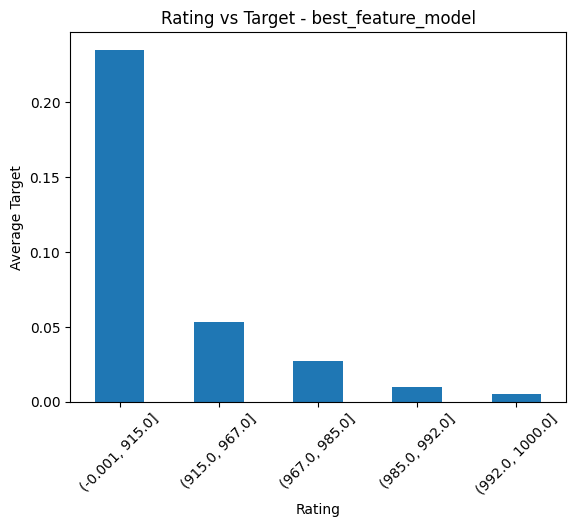

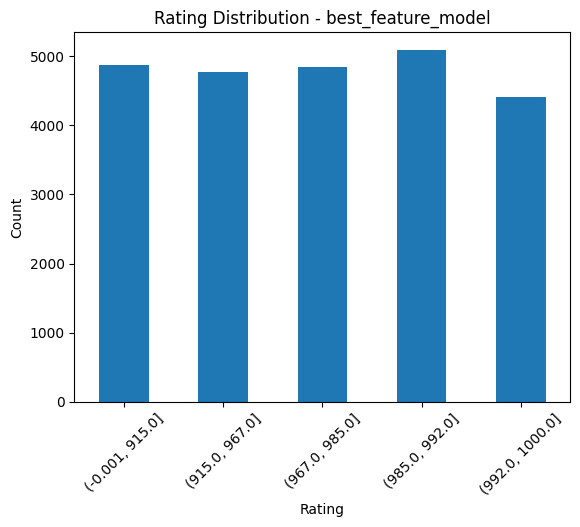

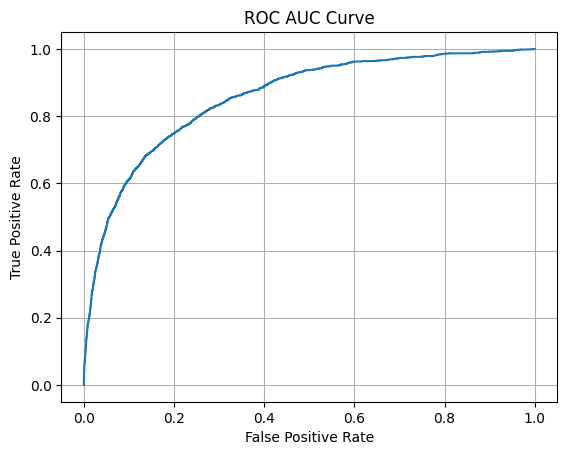

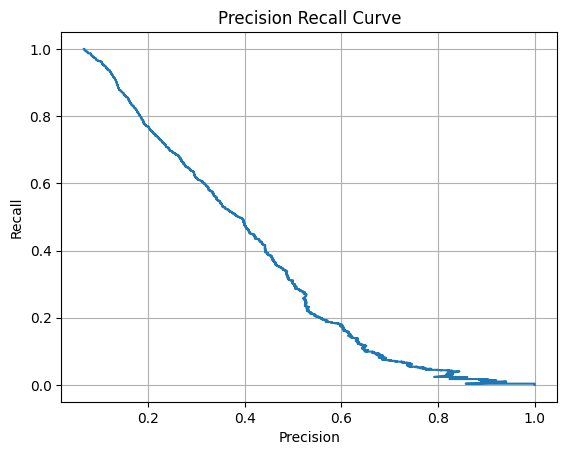

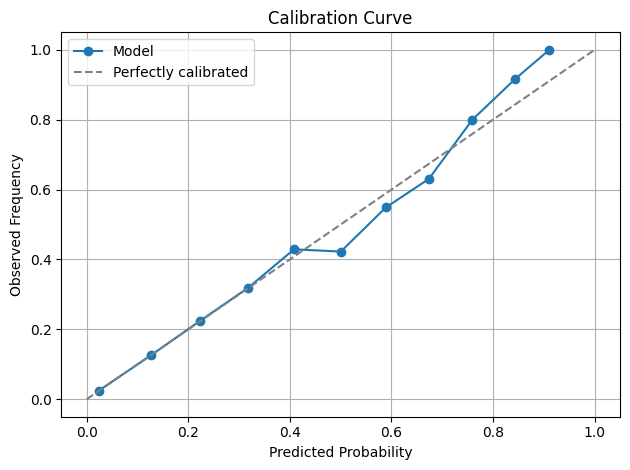

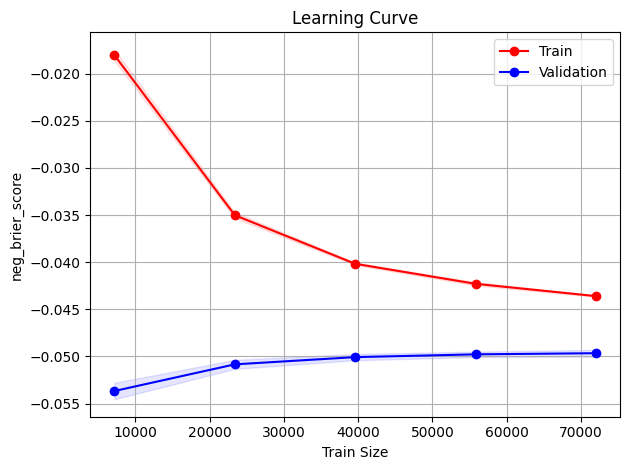

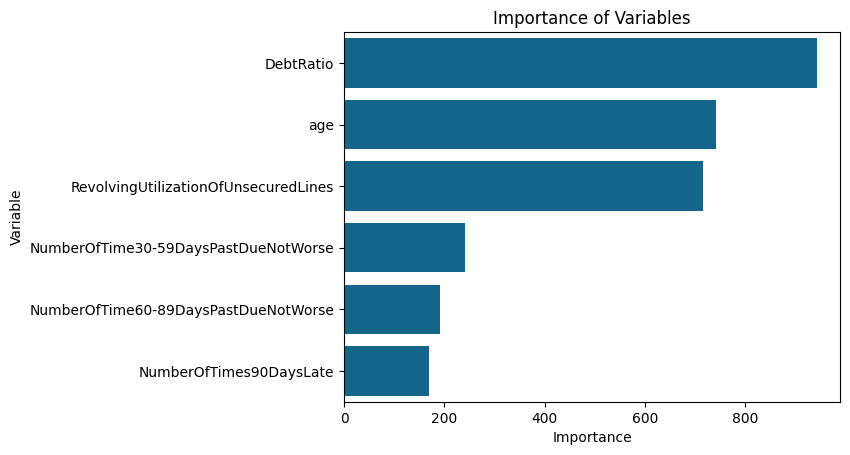

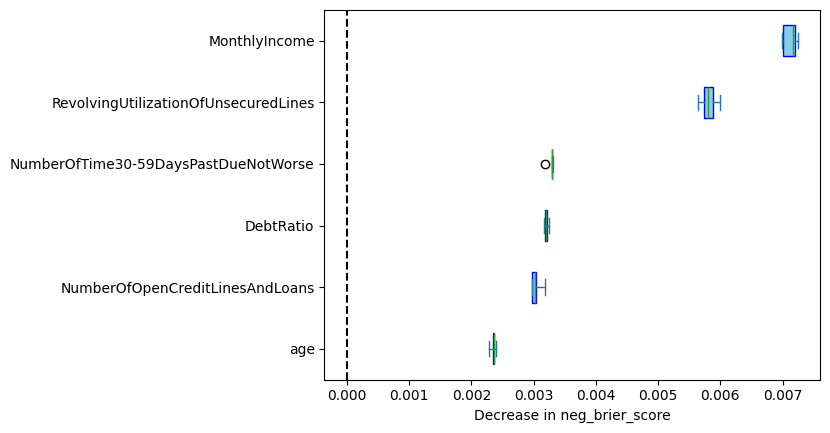

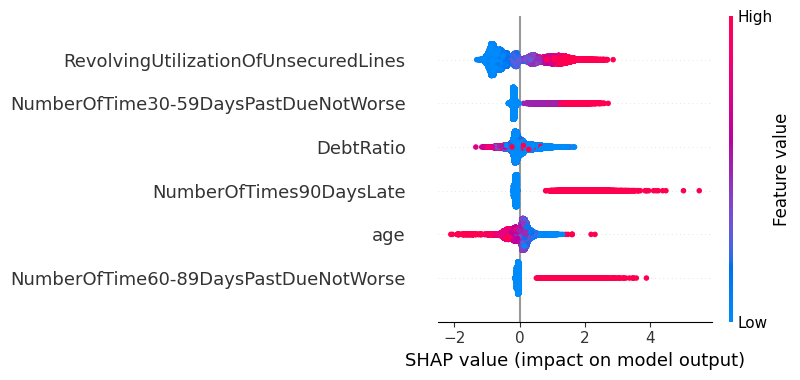

best_params_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0  Train CV  0.500000           0.580335   0.610947  0.168386  0.263759   
1      Test  0.221106           0.714600   0.414278  0.477556  0.443672   

        AUC        KS     Brier  
0  0.859811  0.568751  0.049414  
1  0.857228  0.552451  0.049327

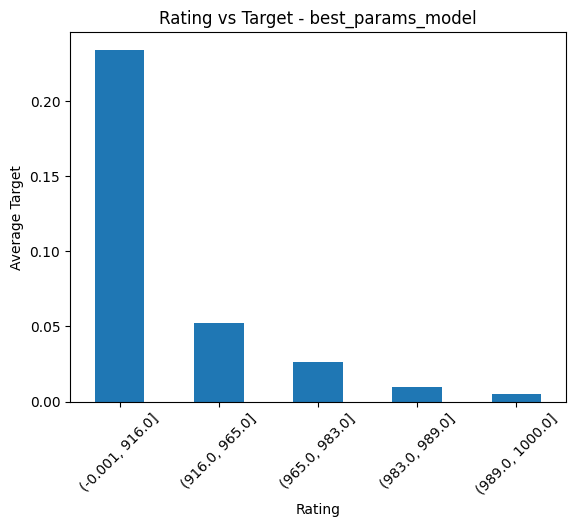

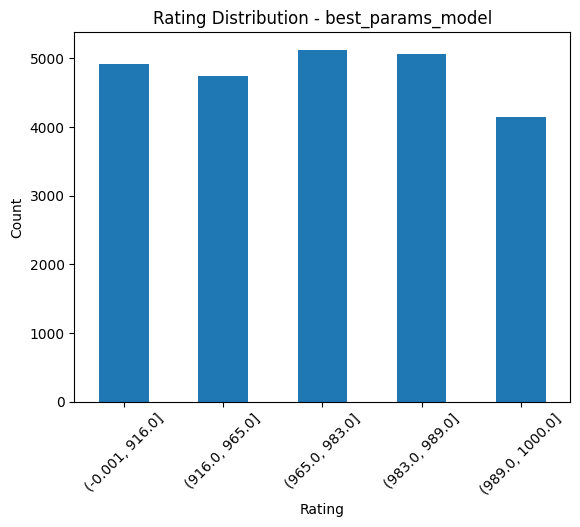

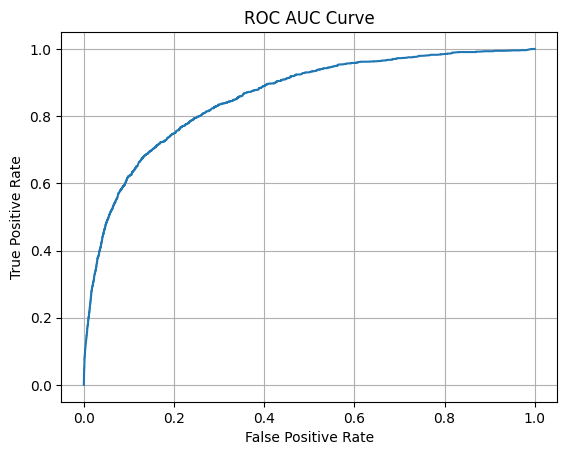

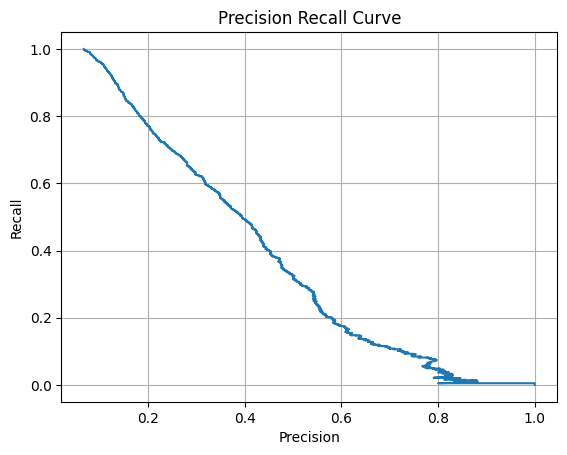

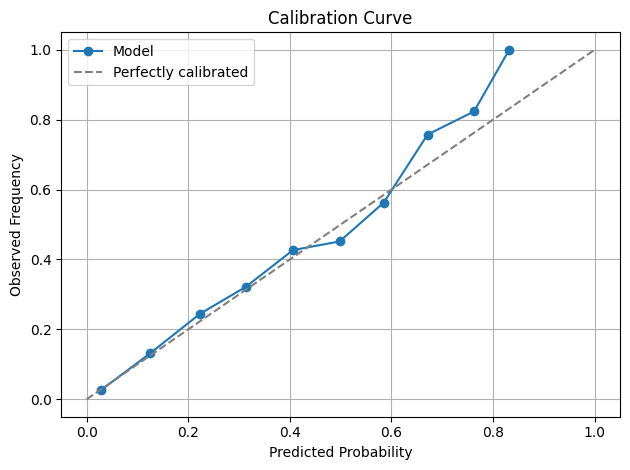

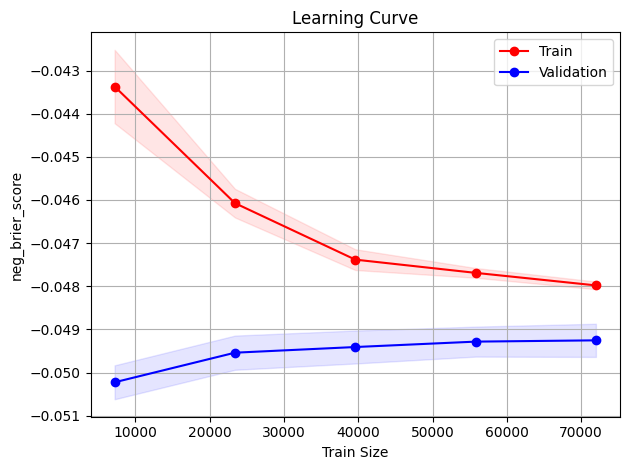

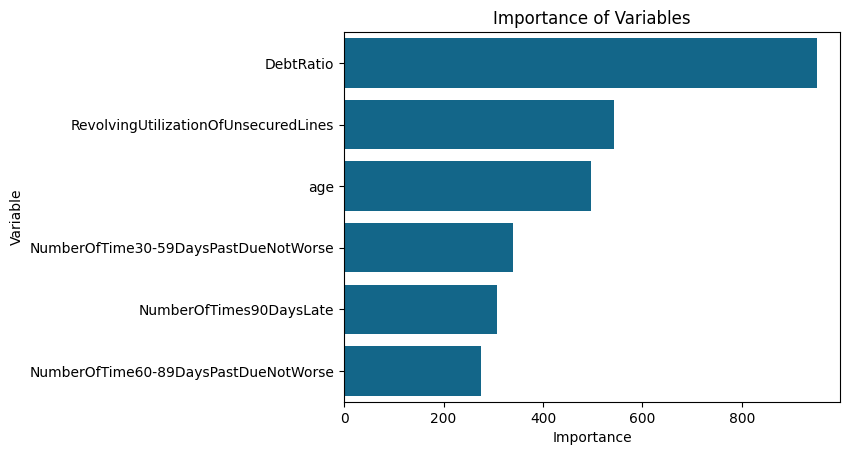

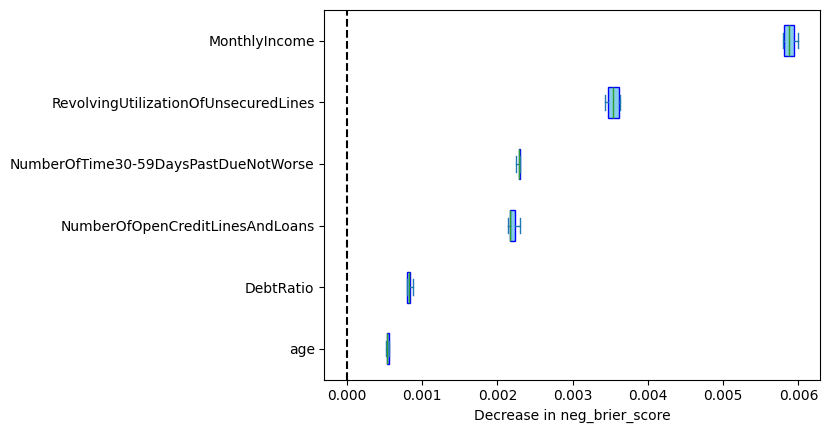

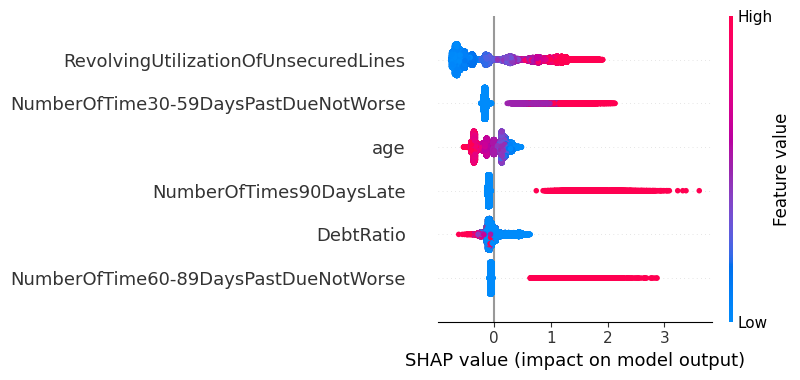

In [16]:
acv.get_result_analysis()

# MultiClass

In [157]:
import shap
import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier

import seaborn as sns

import matplotlib.pyplot as plt

In [133]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.base            import BaseEstimator
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance

In [134]:
from sklearn.metrics import (
    f1_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    brier_score_loss,
    log_loss,
    roc_curve,
    precision_recall_curve,
)

In [135]:
X, y = make_classification(
    n_samples=1000,
    n_classes=3,
    n_features=10,
    n_informative=4,
    n_redundant=6,
    n_clusters_per_class=1,
    random_state=42,
    weights=(0.6, 0.3, 0.1)
)

X = pd.DataFrame(X)
y = pd.DataFrame(y, columns=['target'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.55, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.6, random_state=42)

In [ ]:
def summarize_metric_results(results):
        
    rows = []
    
    for dataset, metrics_dict in results.items():
        row = {"Dataset": dataset}
        row.update(metrics_dict)
        rows.append(row)
    
    return pd.DataFrame(rows)

def get_metrics(y, model_name, target, labels):
    
    return {
        'Balanced Accuracy': balanced_accuracy_score(y[target], y[f'{model_name}_pred']),
        'Precision Macro': precision_score(y[target], y[f'{model_name}_pred'], average='macro'),
        'Recall Macro': recall_score(y[target], y[f'{model_name}_pred'], average='macro'),
        'F1 Macro': f1_score(y[target], y[f'{model_name}_pred'], average='macro'),
        'AUC OVR': roc_auc_score(y[target], y[[f'{model_name}_{label}_prob' for label in labels]], multi_class='ovr'),
        'Log Loss': log_loss(y[target], y[[f'{model_name}_{label}_prob' for label in labels]])
    }

def get_default_model(random_state):
    
    return CatBoostClassifier(random_state=random_state, verbose=0)

def get_params_objective(trial, random_state=42):
    
    return {
        'loss_function': trial.suggest_categorical('loss_function', ['MultiClass']),
        'iterations': trial.suggest_int('iterations', 100, 1000, step=100),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'rsm': trial.suggest_float('rsm', 0.5, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Plain']),
        'random_seed': trial.suggest_categorical('random_seed', [random_state]),
        'verbose': trial.suggest_categorical('verbose', [0]),
        'eval_metric': trial.suggest_categorical('eval_metric', ['MultiClass'])
    }

def get_eval_scoring(scoring, return_func=True):
    
    """
    Returns a scoring function or a valid sklearn scorer string,
    restricted to metrics that are compatible with multiclass classification.

    Parameters:
    - scoring (str): Name of the metric. Supported values: 'roc_auc', 'brier', 'log_loss'
    - return_func (bool): If True, returns a callable function. If False, returns a string for use with sklearn scorers.

    Returns:
    - function or string: The corresponding scoring function or scorer name.

    Raises:
    - ValueError: If the metric is not supported or not compatible with multiclass.
    """

    # Scorer names compatible with sklearn's model evaluation tools
    scorers = {
        'roc_auc': 'roc_auc_ovr',      # Use One-vs-Rest for multiclass
        'log_loss': 'neg_log_loss',    # Log loss works for multiclass
    }

    # Callable metric functions
    functions = {
        'roc_auc': lambda y_true, y_score: roc_auc_score(y_true, y_score, multi_class='ovr'),
        'log_loss': lambda y_true, y_prob: -1 * log_loss(y_true, y_prob),
    }

    if scoring not in scorers or scoring not in functions:
        raise ValueError(f"Metric '{scoring}' is not supported or not compatible with multiclass classification.")

    return functions[scoring] if return_func else scorers[scoring]

def plot_learning_curve(model, X, y, target, scoring, cv=5):

    splitter = StratifiedKFold(cv, shuffle=True, random_state=42)
    
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X, y[target],
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=splitter,
        scoring=scoring
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    # plt.figure(figsize=(10, 6))
    plt.plot(train_sizes_abs, train_scores_mean, 'o-', color='r', label='Train')
    plt.fill_between(
        train_sizes_abs, train_scores_mean - train_scores_std, 
        train_scores_mean + train_scores_std, alpha=0.1, color='r')

    plt.plot(train_sizes_abs, val_scores_mean, 'o-', color='b', label='Validation')
    plt.fill_between(
        train_sizes_abs, val_scores_mean - val_scores_std,
        val_scores_mean + val_scores_std, alpha=0.1, color='b')

    plt.title("Learning Curve")
    plt.xlabel("Train Size")
    plt.ylabel(f"{scoring}")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model):

    feature_names = model.feature_name_ if hasattr(model, 'feature_name_') else model.feature_names_ # for catboost
    
    df_imp = pd.DataFrame(model.feature_importances_, feature_names).reset_index()
    df_imp.columns = ["Variable", "Importance"]
    df_imp = df_imp.sort_values("Importance", ascending=False)

    sns.barplot(x="Importance", y="Variable", color="#006e9cff", data=df_imp[:20])

    plt.title(f"Importance of Variables")
    plt.show()

def plot_permutation_importance_by_labels(model, features, X, y, labels, scoring):
    
    """
    Plots permutation importance (boxplots) for multiple one-vs-rest binary labels.

    Parameters:
    - model_dict: dict mapping label names to trained models (e.g., {'A': model_A, ...})
    - features: list of feature names used in X
    - X: feature matrix (DataFrame)
    - y: DataFrame with one-hot encoded target columns (e.g., 'target_A', 'target_B', ...)
    - scoring: scoring metric to evaluate (e.g. 'roc_auc', 'f1', 'neg_log_loss', etc.)
    """

    for label in labels:
        y_true = y[f'target_{label}']

        # Compute permutation importance
        permu_results = permutation_importance(
            model,
            X[features],
            y_true,
            scoring=scoring,
            n_repeats=5,
            random_state=42
        )

        # Sort importances
        sorted_idx = permu_results.importances_mean.argsort()
        sorted_features = X[features].columns[sorted_idx]

        # Build DataFrame of importances
        df_results = pd.DataFrame(
            permu_results.importances[sorted_idx].T,
            columns=sorted_features
        )

        # Plot boxplot
        plt.figure(figsize=(10, 6))
        ax = df_results.plot.box(
            vert=False,
            whis=10,
            patch_artist=True,
            boxprops={'facecolor': 'skyblue', 'color': 'blue'}
        )
        ax.axvline(x=0, color="k", linestyle="--")
        ax.set_title(f"Permutation Importance - Label {label}")
        ax.set_xlabel(f"Decrease in {scoring}")
        plt.tight_layout()
        plt.show()

def plot_shap_summary(model, features, X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X[features])

    if isinstance(shap_values, list):
        for i, class_shap in enumerate(shap_values):
            print(f"Class {i}")
            shap.summary_plot(class_shap, X[features], show=True)
    else:
        shap.summary_plot(shap_values, X[features])

def analyze_model(model_name, model, results, features, X_train, y_train, y_test, target, labels, scoring):
    
    print(f"{model_name} Results")

    display(summarize_metric_results(results))
        
    plot_roc_curves(y=y_test, model_name=model_name, labels=labels)
    plot_precision_recall_curves(y=y_test, model_name=model_name, labels=labels)
    plot_calibration_curves(y=y_test, model_name=model_name, labels=labels, strategy='uniform')
    plot_learning_curve(model, X_train, y_train, target, scoring=scoring)

    if hasattr(model, 'feature_importances_'):
        plot_feature_importance(model)
    
    plot_permutation_importance_by_labels(model, features, X_train, y_train, labels, scoring=scoring)
    # plot_shap_summary(model, features, X_train)

def plot_precision_recall_curves(y, model_name, labels, show_scores=True):
    
    """
    Plots Precision-Recall curves with F1 score for multiple one-vs-rest binary targets.

    Parameters:
    - y_dummies: DataFrame with one-hot encoded true labels (columns like 'target_{i}')
    - y_probs: DataFrame with predicted probabilities (columns like '{model_name}_{target}_prob')
    - model_name: prefix used in column names of y_probs
    - target_list: list of target identifiers (e.g., class names or labels)
    - show_scores: if True, includes F1 score in the legend
    """

    plt.figure(figsize=(8, 6))

    for label in labels:
        y_true = y[f'target_{label}']
        y_score = y[f'{model_name}_{label}_prob']

        # Compute precision-recall curve
        precision, recall, thresholds = precision_recall_curve(y_true, y_score)

        # Compute F1-score at the default threshold of 0.5
        y_pred = (y_score >= 0.5).astype(int)
        f1 = f1_score(y_true, y_pred)

        label = f'Label {label}'
        if show_scores:
            label += f' (F1: {f1:.3f})'

        plt.plot(recall, precision, label=label)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves for Model: {model_name}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_calibration_curves(y, model_name, labels, n_bins=5, strategy='uniform', show_scores=True):
    
    """
    Plots calibration curves with Brier Score for multiple targets.

    Parameters:
    - y_binary: DataFrame containing the ground truth binary labels (columns like 'target_{i}')
    - y_probs: DataFrame containing predicted probabilities (columns like 'base_model_{i}_prob')
    - target_list: list of target identifiers to evaluate
    - n_bins: number of bins to use in the calibration curve
    - strategy: binning strategy ('uniform' or 'quantile')
    - show_scores: if True, includes Brier Score in the legend
    """
    
    plt.figure(figsize=(8, 6))

    for label in labels:
        y_true = y[f'target_{label}']
        y_pred = y[f'{model_name}_{label}_prob']

        # Compute calibration curve
        prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=n_bins, strategy=strategy)
        
        # Compute Brier Score
        brier = brier_score_loss(y_true, y_pred)

        label = f'Label {label}'
        if show_scores:
            label += f' (Brier: {brier:.3f})'

        plt.plot(prob_pred, prob_true, marker='o', label=label)

    # Plot perfectly calibrated reference line
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Frequency')
    plt.title('Calibration Curves with Brier Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_roc_curves(y, model_name, labels):
    
    """
    Plots ROC curves with AUC for multiple one-vs-rest binary targets.

    Parameters:
    - y: DataFrame with one-hot encoded true labels (columns like 'target_{i}') and 
        DataFrame with predicted probabilities (columns like '{model_name}_{target}_prob')
    - model_name: prefix used in column names of y_probs
    - target_list: list of target identifiers (e.g., class names or labels)
    - show_scores: if True, includes AUC in the legend
    """
    
    plt.figure(figsize=(8, 6))

    for label in labels:
        y_true = y[f'target_{label}']
        y_score = y[f'{model_name}_{label}_prob']

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_score)

        # Compute AUC
        auc = roc_auc_score(y_true, y_score)

        label = f'Label {label}'
        label += f' (AUC: {auc:.3f})'

        plt.plot(fpr, tpr, label=label)

    # Plot random guess line
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for Model: {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

class AutoMLLGBMMultiClassifier():

    def __init__(self, X_train, y_train, X_valid, y_valid, X_test, y_test, best_features, scoring, target, n_trials=50, random_state=42):

        self.X_train = X_train
        self.y_train = y_train
        self.X_valid = X_valid
        self.y_valid = y_valid
        self.X_test = X_test
        self.y_test = y_test
        self.best_features = best_features
        self.target = target
        self.n_trials = n_trials
        self.scorer = get_eval_scoring(scoring, return_func=False)
        self.func_metric = get_eval_scoring(scoring, return_func=True)
        self.random_state = random_state
        self.labels = y_train[target].sort_values().unique().tolist()

    def _train_model(self, model_name, features, model):
        
        model.fit(
            self.X_train[features], self.y_train[self.target],
            eval_set=(self.X_valid[features], self.y_valid[self.target])
        )

        prob_labels_list = [f'{model_name}_{label}_prob' for label in self.labels if label != self.target]
        
        self.y_train[f'{model_name}_pred'] = model.predict(X_train)
        self.y_train[prob_labels_list] = model.predict_proba(self.X_train[features])

        self.y_valid[f'{model_name}_pred'] = model.predict(self.X_valid[features])
        self.y_valid[prob_labels_list] = model.predict_proba(self.X_valid[features])
        
        self.y_test[f'{model_name}_pred'] = model.predict(self.X_test[features])
        self.y_test[prob_labels_list] = model.predict_proba(self.X_test[features])

        results = {
            'Train': get_metrics(self.y_train, model_name, self.target, self.labels),
            'Valid': get_metrics(self.y_valid, model_name, self.target, self.labels),
            'Test': get_metrics(self.y_test, model_name, self.target, self.labels)
        }
        
        return model, results

    def _train_base_model(self):
        
        model = get_default_model(random_state=self.random_state)
        
        return self._train_model('base_model', self.X_train.columns.tolist(), model)

    def _train_best_feature_model(self):
        
        model = get_default_model(random_state=self.random_state)
        
        return self._train_model('best_feature_model', self.best_features, model)

    def _get_best_params(self):

        def objective(trial):
            
            params = get_params_objective(trial, random_state=self.random_state)
    
            model = CatBoostClassifier(**params)
            model.fit(
                self.X_train[self.best_features], self.y_train[self.target],
                eval_set=[(self.X_valid[self.best_features], self.y_valid[self.target])]
            )
    
            preds_proba = model.predict_proba(self.X_valid[self.best_features])
    
            return self.func_metric(self.y_valid[self.target], preds_proba)
    
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=self.n_trials)
    
        return study.best_params

    def _train_best_params_model(self):
        
        best_params = self._get_best_params()
        self.best_params_model = CatBoostClassifier(**best_params)
        
        return self._train_model('best_params_model', self.best_features, self.best_params_model)

    def train(self):
        
        self.base_model, self.base_model_results = self._train_base_model()
        self.best_feature_model, self.best_feature_model_results = self._train_best_feature_model()
        self.best_params_model, self.best_params_model_results = self._train_best_params_model()

    def _create_dummies(self, y):
        """
        Create dummy variables for each class in the target variable.
        """
        y_dummies = pd.get_dummies(y[self.target], prefix=self.target, dtype=int)
        return pd.concat([y,  y_dummies], axis=1)

    def get_metrics(self):

        model_results = {
            "Base Model": self.base_model_results,
            "Best Feature Model": self.best_feature_model_results,
            "Best Params Model": self.best_params_model_results,
        }

        summary_frames = [summarize_metric_results(results).assign(Model=name) for name, results in model_results.items()]

        return pd.concat(summary_frames, ignore_index=True)
    
    def get_result_analysis(self):
    
        self.y_train = self._create_dummies(self.y_train)
        self.y_test = self._create_dummies(self.y_test)

        analyze_model(
            model_name="base_model", 
            model=self.base_model, 
            results=self.base_model_results, 
            features=self.X_train.columns.tolist(), 
            X_train=self.X_train, 
            y_train=self.y_train, 
            y_test=self.y_test, 
            target=self.target, 
            labels=self.labels, 
            scoring=self.scorer
        )
        analyze_model(
            model_name="best_feature_model", 
            model=self.best_feature_model, 
            results=self.best_feature_model_results, 
            features=self.best_features, 
            X_train=self.X_train, 
            y_train=self.y_train, 
            y_test=self.y_test,
            target=self.target, 
            labels=self.labels, 
            scoring=self.scorer
        )
        analyze_model(
            model_name="best_params_model", 
            model=self.best_params_model, 
            results=self.best_params_model_results, 
            features=self.best_features, 
            X_train=self.X_train, 
            y_train=self.y_train, 
            y_test=self.y_test,
            target=self.target, 
            labels=self.labels, 
            scoring=self.scorer
        )

In [191]:
a.labels

[0, 1, 2]

In [192]:
a = AutoMLLGBMMultiClassifier(
    X_train, y_train, X_valid, y_valid, X_test, y_test,
    best_features=X_train.columns.tolist(), scoring='roc_auc', 
    target='target', n_trials=10
)

In [193]:
a.train()

In [194]:
a.get_metrics()

Dataset  Balanced Accuracy  Precision Macro  Recall Macro  F1 Macro  \
0   Train           0.990731         0.996007      0.990731  0.993338   
1   Valid           0.862119         0.935440      0.862119  0.888579   
2    Test           0.790915         0.873016      0.790915  0.820084   
3   Train           0.990731         0.996007      0.990731  0.993338   
4   Valid           0.862119         0.935440      0.862119  0.888579   
5    Test           0.790915         0.873016      0.790915  0.820084   
6   Train           0.990731         0.996007      0.990731  0.993338   
7   Valid           0.860061         0.931630      0.860061  0.885541   
8    Test           0.854741         0.889743      0.854741  0.870218   

    AUC OVR  Log Loss               Model  
0  0.997458  0.075825          Base Model  
1  0.947139  0.289661          Base Model  
2  0.983041  0.223529          Base Model  
3  0.997458  0.075825  Best Feature Model  
4  0.947139  0.289661  Best Feature Model  
5  0.983041  0.223529  Best Feature Model  
6  0.996660  0.079946   Best Params Model  
7  0.950768  0.271145   Best Params Model  
8  0.981413  0.239288   Best Params Model

base_model Results


Dataset  Balanced Accuracy  Precision Macro  Recall Macro  F1 Macro  \
0   Train           0.990731         0.996007      0.990731  0.993338   
1   Valid           0.862119         0.935440      0.862119  0.888579   
2    Test           0.790915         0.873016      0.790915  0.820084   

    AUC OVR  Log Loss  
0  0.997458  0.075825  
1  0.947139  0.289661  
2  0.983041  0.223529

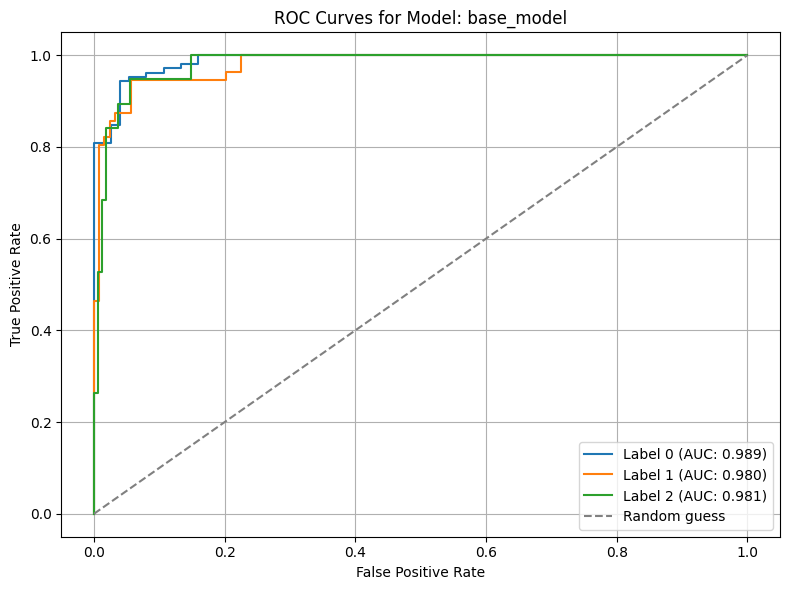

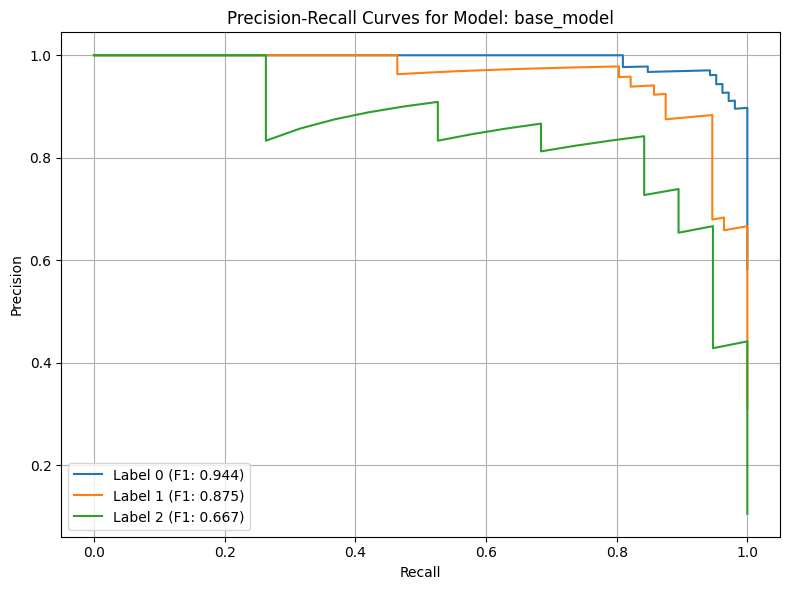

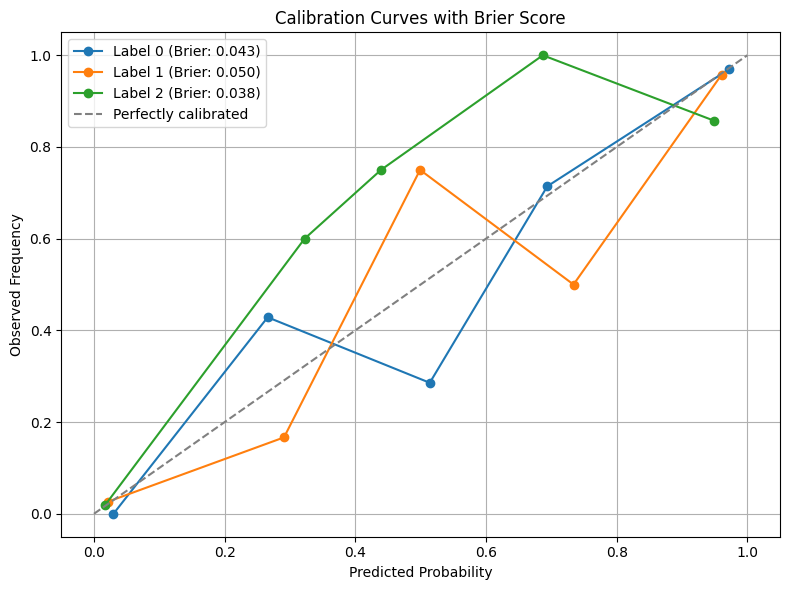

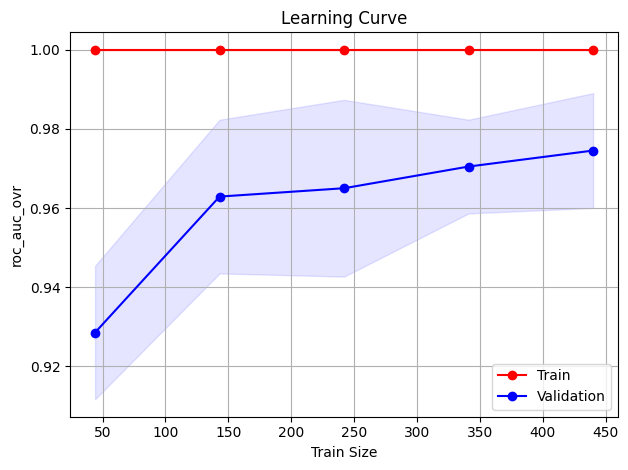

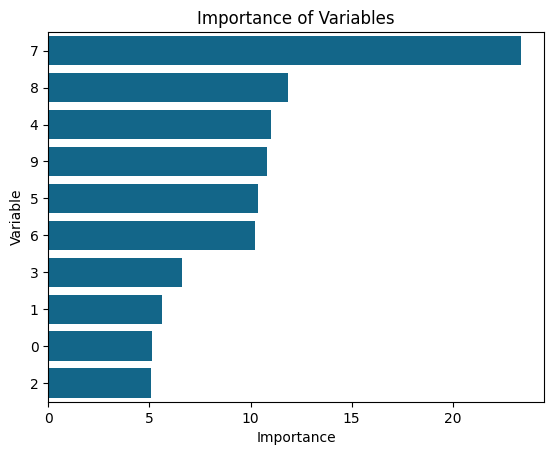

ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

In [195]:
a.get_result_analysis()

In [200]:
plot_permutation_importance_by_labels(
    model=a.best_params_model, 
    features=a.best_features, 
    X=a.X_train, 
    y=a.y_train, 
    labels=a.labels, 
    scoring='roc_auc_ovo'
)

ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'